In [1]:
#  Load the "autoreload" extension so that code can change
%load_ext autoreload
%reload_ext autoreload
#  always reload modules so that as you change code in src, it gets loaded
%autoreload 2
%matplotlib inline

import sys
sys.path.append('../')
import src
from src.imports import *
from src.gen_functions import *
from src.features.map_dataset import MapDataset
# import the Dataset object class
from src.features.dataset import Dataset
from src.features.landuse import *
from src.visualization.mapper import *
from src.visualization.vis_data import *

from src.data.fire_data import process_fire_data, add_datetime_fire, add_merc_to_fire

from zipfile import ZipFile
import io
import geopandas as gpd
from fiona.io import ZipMemoryFile
import fiona
import shutil
import re
import pyproj

# for merging landuse data 
from geopandas.tools import sjoin
from shapely.geometry import Point
from joblib import Parallel
from textwrap import wrap
from collections import defaultdict

plt.rcParams.update({'font.size': 16})

#set bokeh output
output_notebook()

Loading BokehJS ...

In [2]:
map_folder = '../data/world_maps/'
mfire_folder = '../data/fire_map/world_2000-2020/M6_proc/'
vfire_folder = '../data/fire_map/world_2000-2020/V1_proc/'
poll_folder = '../data/poll_map/'
report_folder = '../reports/map/'

# LLD Landuse Level 2 data 

## Understanding Landuse Level 2

In [2]:
ldd_folder = '../data/landuse_idd/'
proc_folder = '../data/landuse_l2/'
temp_folder = ldd_folder + 'temp/'

In [5]:
files = glob('../data/landuse_idd/*.zip')
len(files)
filename = files[5]
print(filename)

../data/landuse_idd\Landuse_กระบี่_2556.zip


In [84]:
# reading file with encoding problem 
with ZipFile(filename, 'r') as zipObj:
    # Get list of files names in zip
    listOfiles = zipObj.namelist()
    # Iterate over the list of file names in given list & print them
    listOfiles = [s.encode('437').decode('iso_8859_11') for s in listOfiles]
    for elem in zipObj.namelist():
        print(elem)
        if '.shp' in elem:
            shape_filename = elem

Landuse_í├╨║╒Φ_2556/00_ReadMe.txt
Landuse_í├╨║╒Φ_2556/Landuse_í├╨║╒Φ_2556.dbf
Landuse_í├╨║╒Φ_2556/Landuse_í├╨║╒Φ_2556.prj
Landuse_í├╨║╒Φ_2556/Landuse_í├╨║╒Φ_2556.sbn
Landuse_í├╨║╒Φ_2556/Landuse_í├╨║╒Φ_2556.sbx
Landuse_í├╨║╒Φ_2556/Landuse_í├╨║╒Φ_2556.shp
Landuse_í├╨║╒Φ_2556/Landuse_í├╨║╒Φ_2556.shx
Landuse_í├╨║╒Φ_2556/Landuse_í├╨║╒Φ_2556.xml


In [85]:
# open the read me file 
with ZipFile(filename) as zipObj:
    f = zipObj.infolist()[0]
     
    data = zipObj.read(f)
    print(data.decode('iso_8859_11'))
     

Datum : 	D_WGS_1984
Projected Coordinate System : WGS_1984_UTM_Zone_47N
Scale : 1 : 25,000
รอบการผลิตข้อมูล : 2553 - 2556
ปีที่ผลิตข้อมูล : 2556
ระดับการใช้ที่ดิน : ระดับ 2 (Level 2)
***หมายเหตุ : ใน 1 รอบการผลิต (4ปี) จะผลิตครบทั้งประเทศ จึงทำให้ช่วงระยะเวลาปี 2553 - 2556 เป็นข้อมูลชุดเดียวกัน


Projected Coordinate System : WGS_1984_UTM_Zone_47N
    
http://12.105.40.62:8080/32647

In [94]:
# extract zip file 
with zipfile.ZipFile(filename,"r") as zip_ref:
    zip_ref.extractall(ldd_folder + 'unzip/')

In [6]:
# read the unzip file
unzip_folder = glob(ldd_folder + 'unzip/' + '*')[0]
unzip_files = glob(unzip_folder + '/*')
for file in unzip_files:
    if '.shp' in file:
        shape_filename = file
print(shape_filename)

../data/landuse_idd/unzip\Landuse_í├╨║╒Φ_2556\Landuse_í├╨║╒Φ_2556.shp


In [7]:
gdf = gpd.read_file(shape_filename, encoding='iso_8859_11')

In [8]:
gdf.head()

,AREA_RAI,Gr,Lu_code,Des_th,Des_en,Shape_Leng,Shape_Area,geometry
0,12.709117,None,A1,พื้นที่นา,Paddy field,639.758463,20334.587305,"POLYGON ((511018.261 831045.602, 511018.689 83..."
1,13.104388,None,A1,พื้นที่นา,Paddy field,956.154283,20967.021599,"POLYGON ((513758.891 833549.075, 513762.693 83..."
2,65.584313,None,A1,พื้นที่นา,Paddy field,1855.614032,104934.900506,"POLYGON ((505651.142 833967.903, 505669.532 83..."
3,92.007969,None,A1,พื้นที่นา,Paddy field,2975.486780,147212.750295,"POLYGON ((506798.578 833577.830, 506783.441 83..."
4,447.802014,None,A1,พื้นที่นา,Paddy field,8975.853720,716483.222890,"POLYGON ((508082.229 835733.218, 508082.045 83..."


In [106]:
gdf.crs

<Projected CRS: EPSG:32647>
Name: WGS 84 / UTM zone 47N
Axis Info [cartesian]:
- E[east]: Easting (metre)
- N[north]: Northing (metre)
Area of Use:
- name: World - N hemisphere - 96°E to 102°E - by country
- bounds: (96.0, 0.0, 102.0, 84.0)
Coordinate Operation:
- name: UTM zone 47N
- method: Transverse Mercator
Datum: World Geodetic System 1984
- Ellipsoid: WGS 84
- Prime Meridian: Greenwich

In [112]:
gdf[['Lu_code','Des_en']].drop_duplicates()

,Lu_code,Des_en
0,A1,Paddy field
350,A2,Field crop
351,A3,Perennial
874,A4,Orchard
1309,A7,Pasture and farm house
1310,A9,Aquacultural land
1839,F1,Evergreen forest
2345,F2,Deciduous forest
2347,F3,Mangrove forest
2703,F5,Forest Plantation


<AxesSubplot:>

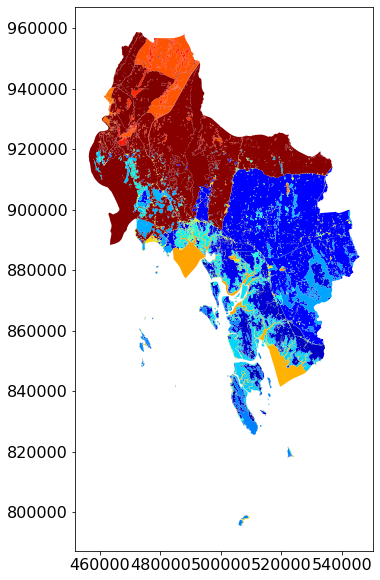

In [12]:
_, ax = plt.subplots(1,1, figsize=(6,10))
gdf['geometry'].plot(cmap='jet', ax=ax)

In [21]:
gdf.groupby('Des_en').sum().sort_values('Shape_Area', ascending=False)

,AREA_RAI,Shape_Leng,Shape_Area
Des_en,,,
Perennial,2.134585e+06,8.854317e+06,3.415336e+09
Evergreen forest,4.431737e+05,3.647424e+06,7.090780e+08
Natural water body,2.865723e+05,2.719085e+06,4.585157e+08
Mangrove forest,2.537240e+05,3.428815e+06,4.059584e+08
Village,4.379791e+04,2.068933e+06,7.007666e+07
Rangeland,3.316667e+04,1.244299e+06,5.306667e+07
Aquacultural land,2.745127e+04,8.292312e+05,4.392203e+07
Paddy field,2.207452e+04,6.704521e+05,3.531922e+07
Orchard,2.156088e+04,7.268848e+05,3.449741e+07


In [38]:
gdf.groupby('Des_en').sum()['Shape_Area'].sum()

5323273812.264699

In [35]:
land_list = []
geo_list = []
for land in gdf['Des_en'].unique():
    temp = gdf[gdf['Des_en'] == land]
    gdf_group = temp['geometry'].unary_union
    land_list.append(land)
    geo_list.append(gdf_group)
    
prov_group = gpd.GeoDataFrame({'Des_en': land_list, 'geometry': geo_list}, crs=gdf.crs)
prov_group['Shape_Area'] = prov_group['geometry'].area

<AxesSubplot:>

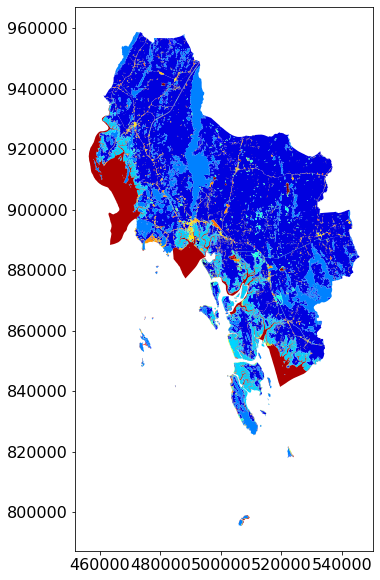

In [37]:
_, ax = plt.subplots(1,1, figsize=(6,10))
prov_group['geometry'].plot(cmap='jet', ax=ax)

In [39]:
prov_group['Shape_Area'].sum()

5323273812.270298

In [44]:
# convert to google map crs
prov_group = prov_group.to_crs(epsg=3857)

In [45]:
center_prov = prov_group['geometry'].unary_union.centroid

In [86]:
prov_boundary = prov_group['geometry'].unary_union

In [87]:
prov_boundary = prov_boundary.boundary 

In [88]:
points = [point for polygon in prov_boundary for point in polygon.coords[:-1]]
points = np.array(points)

In [89]:
[x_min, y_min, x_max, y_max] = prov_group['geometry'].total_bounds
xmap_range = [x_min, x_max]
ymap_range = [y_min, y_max]

In [90]:
x_center = center_prov.x
y_center = center_prov.y

In [91]:
p = figure(x_range=xmap_range, y_range=ymap_range, x_axis_type="mercator", y_axis_type="mercator",  toolbar_location='below', 
           plot_width=500, plot_height=500, title='')
p.add_tile(get_provider(Vendors.STAMEN_TERRAIN_RETINA))

p.circle(points[:,0], points[:,1], size=1)

show(p)

In [82]:
# try saving

prov_group.to_file(proc_folder + "try.shp")

In [83]:
prov_group = gpd.read_file(proc_folder + "try.shp")

In [84]:
prov_group

,Des_en,Shape_Area,geometry
0,Paddy field,3.531922e+07,"MULTIPOLYGON (((11031747.198 839344.045, 11031..."
1,Field crop,3.918406e+04,"MULTIPOLYGON (((11025311.365 924642.239, 11025..."
2,Perennial,3.415336e+09,"MULTIPOLYGON (((11032752.621 835875.871, 11032..."
3,Orchard,3.449741e+07,"MULTIPOLYGON (((11043956.027 826639.588, 11043..."
4,Pasture and farm house,1.009170e+05,"MULTIPOLYGON (((11008514.458 911227.335, 11008..."
5,Aquacultural land,4.392203e+07,"MULTIPOLYGON (((11029825.476 842005.428, 11029..."
6,Evergreen forest,7.090780e+08,"MULTIPOLYGON (((11027537.238 805250.782, 11027..."
7,Deciduous forest,2.152945e+05,"MULTIPOLYGON (((11018544.091 890410.446, 11018..."
8,Mangrove forest,4.059584e+08,"MULTIPOLYGON (((11030675.633 841334.638, 11030..."
9,Forest Plantation,1.453565e+07,"MULTIPOLYGON (((11039430.849 879152.974, 11039..."


Search for all shape files

In [92]:
files = glob('../data/landuse_idd/*.zip')
len(files)
filename = files[5]
print(filename)

../data/landuse_idd\Landuse_กระบี่_2556.zip


## Build landuse level 2

In [335]:
ldd_folder = '../data/landuse_idd/'
proc_folder = '../data/landuse_l2/'
temp_folder = ldd_folder + 'temp/'

In [323]:
files = glob(ldd_folder + "*.zip")
print(len(files))
zip_file_pairs = []

empty_files = []
good_files = []
double_files = []

for file in files:
    # reading file with encoding problem 
    with ZipFile(file, 'r') as zipObj:
        # Get list of files names in zip
        # listOfiles = zipObj.namelist()
        # Iterate over the list of file names in given list & print them
        #listOfiles = [s.encode('437').decode('iso_8859_11') for s in listOfiles]
        
        year = file.split('_')[-1].split('.')[0]
        
        for elem in zipObj.namelist():
             
            if 'ReadMe' in elem:
                readme_file = elem
                
        with_shape = False       
        shape_count = 0
        for elem in zipObj.namelist():
             
            if ('.shp' in elem) and ('xml' not in elem) and ('CIT') not in elem:
                shape_filename = elem
                zip_file_pairs.append([file, shape_filename, readme_file, year])
                with_shape = True
                shape_count += 1
                
        if with_shape:
            good_files.append(file)
        else:
            empty_files.append(file)
        
        if shape_count > 1:
            double_files.append(file)
            
             

zip_file_pairs = np.array(zip_file_pairs)

zip_file_pairs = pd.DataFrame(zip_file_pairs)
print(len(zip_file_pairs))

print(len(empty_files), len(good_files), len(double_files))

923
797
126 797 0


In [94]:
shape_filename.encode('437').decode('iso_8859_11') 

'Landuse_กระบี่_2556/Landuse_กระบี่_2556.shp'

In [248]:
shutil.rmtree(unzip_folder)

In [532]:
i

42

In [536]:
[zip_filename, shape_filename, readme_filename, year] = zip_file_pairs.iloc[42].to_list()

In [537]:
shape_filename

'Landuse_í╥╠╩╘╣╕╪∞_2562/¿╤º╦╟╤┤í╥╠╩╘╣╕╪∞.shp'

In [524]:
# extract zip file 
with ZipFile(zip_filename, "r") as zip_ref:
    zip_ref.extractall(temp_folder)

In [525]:
# unzip folder to be delete afterward 
unzip_folder = glob(temp_folder + '/*')[0] + '/'

print(unzip_folder)

# prepare new shape file
shape_filename = temp_folder + shape_filename

print(shape_filename)

../data/landuse_idd/temp\Landuse_¬┼║╪├╒_2550/
../data/landuse_idd/temp/Landuse_╣ñ├╛╣┴_2550/Landuse_╣ñ├╛╣┴_25450.shp


In [502]:
[prov_name, year] = shape_filename.encode('437').decode('iso_8859_11').split('_')[-2:]
#year = year.split('.')[0]

year

'25450.shp'

In [503]:
# read unzip file 
prov_land = gpd.read_file(shape_filename, encoding='iso_8859_11', SHAPE_RESTORE_SHX=True)
# change crs to mercator
prov_land = prov_land.to_crs(epsg=3857)

ERROR:fiona._env:Unable to open ../data/landuse_idd/temp/Landuse_╣ñ├╛╣┴_2550/Landuse_╣ñ├╛╣┴_25450.shx or ../data/landuse_idd/temp/Landuse_╣ñ├╛╣┴_2550/Landuse_╣ñ├╛╣┴_25450.SHX. Set SHAPE_RESTORE_SHX config option to YES to restore or create it.


DriverError: Unable to open ../data/landuse_idd/temp/Landuse_╣ñ├╛╣┴_2550/Landuse_╣ñ├╛╣┴_25450.shx or ../data/landuse_idd/temp/Landuse_╣ñ├╛╣┴_2550/Landuse_╣ñ├╛╣┴_25450.SHX. Set SHAPE_RESTORE_SHX config option to YES to restore or create it.

In [373]:
for land in prov_land['Des_en'].unique(): 
    temp = prov_land[prov_land['Des_en'] == land]
    if len(temp) > 0:
        #temp['geometry'] = temp['geometry'].buffer(0)
        gdf_group = temp['geometry'].unary_union

TopologyException: Input geom 1 is invalid: Self-intersection at or near point 11236404.482856957 1604719.402313302 at 11236404.482856957 1604719.402313302


ValueError: No Shapely geometry can be created from null value

In [120]:
# group by landuse 
group_land = group_gdf_bylanduse(prov_land)
readme_filename = temp_folder + readme_filename
start_year, end_year = extract_year_range(readme_filename)

In [491]:
# extract province name and year of survey
print(shape_filename)
[prov_name, year] = shape_filename.encode('437').decode('iso_8859_11').split('_')[-2:]
print(year)

result = re.search('(\d{4})', year)
year = result.group(0)

print(year)

../data/landuse_idd/temp/Landuse_╣ñ├╛╣┴_2550/Landuse_╣ñ├╛╣┴_25450.shp
25450.shp
2545


In [122]:
# add meta information
group_land['province'] = prov_name
group_land['year'] = int(year) - 543 
group_land['start_year'] = start_year 
group_land['end_year'] = end_year 

,Des_en,geometry
0,Paddy field,"MULTIPOLYGON (((511094.297 830864.726, 511093...."
1,Field crop,"MULTIPOLYGON (((504631.475 914949.824, 504609...."
2,Perennial,"MULTIPOLYGON (((512143.438 827943.008, 512137...."
3,Orchard,"MULTIPOLYGON (((523123.970 818540.138, 523123...."
4,Horticulture,"POLYGON ((503996.608 877440.694, 503997.891 87..."
5,Aquaculture land,"MULTIPOLYGON (((509113.215 833665.380, 509107...."
6,Disturbed forest land,"MULTIPOLYGON (((503836.800 839097.923, 503788...."
7,Dense forest land,"MULTIPOLYGON (((506850.582 797467.218, 506858...."
8,Miscellaneous land,"MULTIPOLYGON (((506947.913 795662.493, 506935...."
9,Marsh and Swamp,"MULTIPOLYGON (((504167.781 835826.230, 504164...."


In [32]:
def group_gdf_bylanduse(gdf, col='Des_en', to_print=False):
    land_list = []
    geo_list = []
    for land in tqdm(gdf[col].unique()):
            
        temp = gdf[gdf[col] == land]
        if (len(temp) > 0):
            temp['geometry'] = temp['geometry'].buffer(0)
            gdf_group = temp['geometry'].unary_union
            land_list.append(land)
            geo_list.append(gdf_group)
    
    return gpd.GeoDataFrame({'des_en': land_list, 'geometry': geo_list}, crs=gdf.crs)

In [5]:
def extract_year_range(readme_filename):
    
    with open(readme_filename, encoding='iso_8859_11') as f:
        readme_txt = f.read()
    
    year_range = [s for s in readme_txt.split('\n') if 'รอบการผลิตข้อมูล' in s]
    year_range = year_range[0]
    
    year_split = year_range.split(':')[-1].split('-')
    if len(year_split) == 2:
        [start_year, end_year] = year_split
    elif len(year_split) ==1:
        start_year = end_year = year_split[0]
    start_year = int(start_year) - 543 
    end_year = int(end_year) - 543 
    
    return start_year, end_year

In [6]:
def build_prov_group(zip_filename, shape_filename, readme_filename, ld_folder = '../data/landuse_idd/', fix_encode=True):
    
    temp_folder = ld_folder + 'temp/'
    # extract zip file 
    with ZipFile(zip_filename, "r") as zip_ref:
        zip_ref.extractall(temp_folder)
        
    # unzip folder to be delete afterward 
    # unzip_folder = '/'.join(shape_filename.split('/')[:-1]) + '/'

    # prepare new shape file
    shape_filename = temp_folder  + shape_filename
    # fix one bad file
    if '25450' in shape_filename:
        old_file = shape_filename
        new_file = old_file.replace('25450', '2550') 
        shape_filename = new_file
        if not os.path.exists(new_file):
            os.rename(old_file, new_file)
        
        
    # read unzip file 
    prov_land = gpd.read_file(shape_filename, encoding='iso_8859_11')
    # make all columns lower case 
    new_col = [s.lower() for s in prov_land.columns]
    prov_land.columns = new_col
    
    #print(prov_land.columns)
    
    if len(prov_land.columns) > 1:
        label_col = []
        if 'des_en' in prov_land.columns:
            col = 'des_en'
            label_col = [ 'des_th', 'des_en']
         
        elif 'lu_des_en' in prov_land.columns:
            col = 'lu_des_en'
            label_col = ['lu_des_th', 'lu_des_en']
        else:
            print(prov_land.columns)
    
        if 'lu_group' in prov_land.columns:
            label_col += ['lu_group']
        elif 'lu_groub' in prov_land.columns:
            label_col += ['lu_groub']
        elif 'lu_code' in prov_land.columns:
            label_col += ['lu_code']
         
        else:
            print(prov_land.columns)
        # change crs to mercator
        prov_land = prov_land.to_crs(epsg=3857)
        label_df = prov_land[label_col].drop_duplicates()
    
        # group by landuse 
        group_land = group_gdf_bylanduse(prov_land, col=col)
        
        if len(readme_filename)>0:
            # use readme to extract year 
            readme_filename = temp_folder + readme_filename
            start_year, end_year = extract_year_range(readme_filename)
        else:
            start_year = end_year = np.nan 
    
        # extract province name and year of survey
        if fix_encode:
            [prov_name, year] = shape_filename.encode('437').decode('iso_8859_11').split('_')[-2:]
            result = re.search('(\d{4})', year)
            year = result.group(0)
        else:
            result = re.search('/(\D+)(\d{4})/',shape_filename)
            prov = result.group(1)
            year = result.group(2)
            
        
        if year == '2545':
            year = '2550'
    
        # add meta information
        group_land['province'] = prov_name
        group_land['year'] = int(year) - 543 
        group_land['start_year'] = start_year 
        group_land['end_year'] = end_year 
    
    else:
        group_land = pd.DataFrame()
        label_df = pd.DataFrame()
    
    
    return group_land, label_df

In [546]:
zip_file_pairs[3].unique()

array(['2551', '2552', '2553', '2554', '2555', '2556', '2559', '2560',
       '2561', '2550', '2558', '2562'], dtype=object)

In [547]:
label_all = []

for year in ['2562', '2560' ]:
    
    print(year)
    
    save_folder = proc_folder + str(year) + '/'
    if not os.path.exists(save_folder):
        os.mkdir(save_folder)
    
    save_filename = save_folder + str(year) + '.shp'
    
    # select file for that year
    temp = zip_file_pairs[zip_file_pairs[3] == year]
    
    year_gdf = []
    
    
    for i, row in tqdm(temp.iterrows()):
    
        [zip_filename, shape_filename, readme_filename, year] = row.to_list()
        
        # print(zip_filename)
        
        group_gdf, label_df = build_prov_group(zip_filename, shape_filename, readme_filename, ld_folder=ldd_folder )
        year_gdf.append(group_gdf)
        label_all.append(label_df)
        
    # remove unzip files
    rm_files = glob(ldd_folder +  'temp/' + '*')
    # remove unzip files 
    for rm_file in rm_files:
        try:
            shutil.rmtree(rm_file)
        except OSError:
            os.remove(rm_file)  
    
    if len(year_gdf) > 0:
        
        year_gdf = pd.concat(year_gdf, ignore_index=True)
        year_gdf.to_file(save_filename, encoding = 'utf-8')

label_all = pd.concat(label_all, ignore_index=True)
label_all.to_csv(proc_folder + 'level2_labels.csv', index=False, encoding = 'utf-8')


2562
















0it [00:00, ?it/s]













1it [12:02, 722.51s/it]













2it [26:03, 758.02s/it]













3it [37:11, 730.97s/it]













4it [58:34, 896.61s/it]













5it [1:03:42, 719.95s/it]













6it [1:09:20, 605.36s/it]













7it [1:12:23, 478.87s/it]













8it [1:13:36, 356.97s/it]













9it [1:15:45, 288.69s/it]













10it [1:20:44, 291.83s/it]













11it [1:28:55, 351.51s/it]













12it [1:36:18, 379.01s/it]













13it [1:41:07, 351.78s/it]













14it [1:43:09, 282.85s/it]













15it [1:44:33, 223.45s/it]













16it [1:47:07, 202.39s/it]













17it [1:57:19, 325.31s/it]













18it [2:10:39, 467.86s/it]













19it [2:18:14, 436.56s/it]


2560
















0it [00:00, ?it/s]













1it [02:39, 159.14s/it]













2it [02:48, 114.13s/it]













3it [12:14, 249.62s/it]













4it [21:12, 336.39s/it]













5it [27:56, 356.60s/it]













6it [40:15, 471.30s/it]













7it [41:53, 359.17s/it]













8it [43:28, 280.18s/it]













9it [43:31, 196.95s/it]













10it [44:20, 152.62s/it]













11it [54:38, 292.13s/it]













12it [57:36, 257.96s/it]













13it [1:02:48, 274.17s/it]













14it [1:03:00, 195.38s/it]













15it [1:03:33, 146.84s/it]













16it [1:56:27, 1055.02s/it]













17it [2:01:59, 837.85s/it] 













18it [2:04:36, 633.73s/it]













19it [2:07:59, 504.55s/it]













20it [2:08:12, 356.94s/it]













21it [2:09:09, 267.04s/it]













22it [2:09:41, 196.66s/it]













23it [2:10:12, 146.97s/it]













24it [2:10:31, 108.59s/it]













25it [2:13:06, 122.32s/it

In [384]:
save_filename

'../data/landuse_l2/2552/2552shp'

In [386]:
year_gdf = gpd.read_file(save_filename, encoding = 'utf-8')  

In [404]:
year_gdf.tail()

,des_en,province,year,start_year,end_year,geometry
959,Perennial,?????????,2008,2008,2009,"MULTIPOLYGON (((10899580.976 2038325.467, 1089..."
960,Horticulture,?????????,2008,2008,2009,"MULTIPOLYGON (((10900611.795 2048863.686, 1090..."
961,Pasture and farm house,?????????,2008,2008,2009,"MULTIPOLYGON (((10901294.659 2062400.918, 1090..."
962,Aquacultural land,?????????,2008,2008,2009,"MULTIPOLYGON (((10900044.313 2132379.796, 1090..."
963,Integrated farm/Diversified farm,?????????,2008,2008,2009,"MULTIPOLYGON (((10961973.749 2189217.226, 1096..."


check label data

In [25]:
l2_label = pd.read_csv(proc_folder + 'level2_labels.csv', encoding = 'utf-8')
l2_label.head()

,lu_des_th,lu_des_en,lu_code
0,เกษตรผสมผสาน/ไร่นาสวนผสม,Integrated farm/Diversified farm,A0
1,พื้นที่นา,Paddy field,A1
2,พืชไร่,Field crop,A2
3,พืชไร่/ไม้ยืนต้น,Field crop/Perennial crop,A2/A3
4,พืชไร่/ไม้ผล,Field crop/Orchard,A2/A4


In [24]:
l2_label.to_csv(proc_folder + 'level2_labels.csv', encoding = 'utf-8', index=False)

Need to replace + with / for all of these columns.

## Merge data to remove province information

In [4]:
files = glob(proc_folder + '*prov/*.shp')
files

['../data/landuse_l2\\2550_prov\\2550.shp',
 '../data/landuse_l2\\2551_prov\\2551.shp',
 '../data/landuse_l2\\2552_prov\\2552.shp',
 '../data/landuse_l2\\2553_prov\\2553.shp',
 '../data/landuse_l2\\2554_prov\\2554.shp',
 '../data/landuse_l2\\2555_prov\\2555.shp',
 '../data/landuse_l2\\2556_prov\\2556.shp',
 '../data/landuse_l2\\2558_prov\\2558.shp',
 '../data/landuse_l2\\2559_prov\\2559.shp',
 '../data/landuse_l2\\2560_prov\\2560.shp',
 '../data/landuse_l2\\2561_prov\\2561.shp',
 '../data/landuse_l2\\2562_prov\\2562.shp']

In [8]:
# Build all pollution data
mdataset = MapDataset('Thailand')
mdataset.load_()
prov_dict = mdataset.prov_map[['admin1Name_th', 'province']]
prov_dict.columns = ['prov_th', 'province']

In [25]:
def proc_prov(s):
    replace_dict = {'จ.':'',
                    'จ.จันทบุรี':'จันทบุรี',
                    'จ.ชัยนาท': 'ชัยนาท',
                    'จ.ปราจีนบุรี': 'ปราจีนบุรี',
                    'จ.พระนครศรีอยุธยา': 'พระนครศรีอยุธยา',
                    'จ.เพชรบูรณ์': 'เพชรบูรณ์',
                   'กาญบุรี': 'กาญจนบุรี',
                   'นทบุรี':   'นนทบุรี',
                    'ประบคีรีขันธ์': 'ประจวบคีรีขันธ์', 
                    'ปรานบุรี': 'ปราจีนบุรี', 
                    'พิตร': 'พิจิตร', 
                    'อำนาิญ': 'อำนาจเจริญ',
                    'แม่ฮองสอน': 'แม่ฮ่องสอน'
                   }
    s = s.replace(replace_dict)
    #s = s.str.replace('กาญบุรี', 'กาญจนบุรี')
    #s = s.str.replace('กาญบุรี', 'กาญจนบุรี')
    #s = s.str.replace('นทบุรี', )
    s = s.str.lstrip()
    s = s.str.rstrip()
    return s

def proc_label(s):
    s = s.str.replace('+', '/')
    s = s.str.replace('Integrated farm/ Diversified farm', 'Integrated farm/Diversified farm')
    return s.str.lower()

In [10]:
#gdf0 = gpd.read_file(files[2])
gdf1 = gpd.read_file(files[3])
gdf2 = gpd.read_file(files[4])
gdf3 = gpd.read_file(files[5])

In [11]:
#gdf0['province'] = proc_prov(gdf0['province'] )
gdf1['province'] = proc_prov(gdf1['province'] )
gdf2['province'] = proc_prov(gdf2['province'] )
gdf3['province'] = proc_prov(gdf3['province'] )

name_dict = {'province':'prov_th'}
#gdf0 = gdf0.rename(columns= name_dict)
gdf1 = gdf1.rename(columns= name_dict)
gdf2 = gdf2.rename(columns= name_dict)
gdf3 = gdf3.rename(columns= name_dict)

In [12]:
#gdf0['des_en'] =  proc_label(gdf0['des_en'])
gdf1['des_en'] =  proc_label(gdf1['des_en'])
gdf2['des_en'] =  proc_label(gdf2['des_en'])
gdf3['des_en'] =  proc_label(gdf3['des_en'])

In [26]:
gdf1['prov_th'] = proc_prov(gdf1['prov_th'] )

In [28]:
gdf1['prov_th'].unique()

array(['กระบี่', 'กรุงเทพมหานคร', 'กาญจนบุรี', 'กาฬสินธุ์', 'กำแพงเพชร',
       'ขอนแก่น', 'จันทบุรี', 'ฉะเชิงเทรา', 'ชลบุรี', 'ชัยนาท', 'ชัยภูมิ',
       'ชุมพร', 'ตราด', 'ตาก', 'นครนายก', 'นครปฐม', 'นครพนม',
       'นครราชสีมา', 'น่าน', 'บึงกาฬ', 'บุรีรัมย์', 'ปทุมธานี',
       'ประจวบคีรีขันธ์', 'ปราจีนบุรี', 'ปัตตานี', 'พระนครศรีอยุธยา',
       'พะเยา', 'พังงา', 'พัทลุง', 'พิจิตร', 'พิษณุโลก', 'ภูเก็ต',
       'มหาสารคาม', 'มุกดาหาร', 'ยะลา', 'ยโสธร', 'ระนอง', 'ระยอง',
       'ราชบุรี', 'ร้อยเอ็ด', 'ลพบุรี', 'ลำปาง', 'ลำพูน', 'ศรีสะเกษ',
       'สกลนคร', 'สงขลา', 'สตูล', 'สมุทรปราการ', 'สมุทรสงคราม',
       'สมุทรสาคร', 'สระบุรี', 'สระแก้ว', 'สิงห์บุรี', 'สุพรรณบุรี',
       'สุราษฎร์ธานี', 'สุรินทร์', 'สุโขทัย', 'หนองคาย', 'หนองบัวลำภู',
       'อำนาจเจริญ', 'อุดรธานี', 'อุตรดิตถ์', 'อุทัยธานี', 'อุบลราชธานี',
       'อ่างทอง', 'เชียงราย', 'เพชรบุรี', 'เพชรบูรณ์', 'เลย', 'แพร่',
       'แม่ฮ่องสอน'], dtype=object)

In [30]:
temp = gdf2[~gdf2['prov_th'].isin(gdf1['prov_th'].unique())]
print(temp['prov_th'].unique())
gdf1 = pd.concat([gdf1, temp], ignore_index=True)

temp = gdf3[~gdf3['prov_th'].isin(gdf1['prov_th'].unique())]
print(temp['prov_th'].unique())
gdf1 = pd.concat([gdf1, temp], ignore_index=True)

['จ.จันทบุรี' 'จ.ชัยนาท' 'จ.ปราจีนบุรี' 'จ.พระนครศรีอยุธยา' 'จ.เพชรบูรณ์']
['เชียงใหม่']


In [ ]:
gdf1['prov_th'].nunique()

In [46]:
new_gdf1 = gdf1.merge(prov_dict, on='prov_th', how='left')
new_gdf1[new_gdf1['province'].isna()]['prov_th'].unique()

In [21]:
year = '2553'
year = str(int(year) - 543 )

save_folder = proc_folder + year + '/'
try:
    os.mkdir(save_folder)
except:
    pass
save_filename = save_folder + year + '.shp'
print(save_filename)

../data/landuse_l2/2007/2007.shp


In [49]:
#gdf1['year'] = year
new_gdf1[['des_en', 'year', 'geometry', 'province']].to_file(save_filename)

In [57]:
year = '2551'
year = str(int(year) - 543 )

save_folder = proc_folder + year + '/'
try:
    os.mkdir(save_folder)
except:
    pass
save_filename = save_folder + year + '.shp'
print(save_filename)

../data/landuse_l2/2008/2008.shp


In [51]:
temp = gdf1[~gdf1['prov_th'].isin(gdf2['prov_th'].unique())]
print(temp['prov_th'].unique())
gdf2 = pd.concat([gdf2, temp], ignore_index=True)

temp = gdf3[~gdf3['prov_th'].isin(gdf2['prov_th'].unique())]
print(temp['prov_th'].unique())
gdf2 = pd.concat([gdf2, temp], ignore_index=True)


['เชียงราย']
[]


In [52]:
gdf2['prov_th'].nunique()

72

In [53]:
gdf2['prov_th'].unique()

array(['กระบี่', 'กรุงเทพมหานคร', 'กาญจนบุรี', 'กาฬสินธุ์', 'กำแพงเพชร',
       'ขอนแก่น', 'นนทบุรี', 'ฉะเชิงเทรา', 'ชลบุรี', 'ชัยนาท', 'ชัยภูมิ',
       'ชุมพร', 'ตราด', 'ตาก', 'นครนายก', 'นครปฐม', 'นครพนม',
       'นครราชสีมา', 'น่าน', 'บึงกาฬ', 'บุรีรัมย์', 'ปทุมธานี',
       'ประจวบคีรีขันธ์', 'ปราจีนบุรี', 'ปัตตานี', 'พระนครศรีอยุธยา',
       'พะเยา', 'พังงา', 'พัทลุง', 'พิจิตร', 'พิษณุโลก', 'ภูเก็ต',
       'มหาสารคาม', 'มุกดาหาร', 'ยะลา', 'ยโสธร', 'ระนอง', 'ระยอง',
       'ราชบุรี', 'ร้อยเอ็ด', 'ลพบุรี', 'ลำปาง', 'ลำพูน', 'ศรีสะเกษ',
       'สกลนคร', 'สงขลา', 'สตูล', 'สมุทรปราการ', 'สมุทรสงคราม',
       'สมุทรสาคร', 'สระบุรี', 'สระแก้ว', 'สิงห์บุรี', 'สุพรรณบุรี',
       'สุราษฎร์ธานี', 'สุรินทร์', 'สุโขทัย', 'หนองคาย', 'หนองบัวลำภู',
       'อำนาจเจริญ', 'อุดรธานี', 'อุตรดิตถ์', 'อุทัยธานี', 'อุบลราชธานี',
       'อ่างทอง', 'เชียงใหม่', 'เพชรบุรี', 'เพชรบูรณ์', 'เลย', 'แพร่',
       'แม่ฮ่องสอน', 'เชียงราย'], dtype=object)

In [58]:
gdf2['prov_th'] = proc_prov(gdf2['prov_th'] )
new_gdf2 = gdf2.merge(prov_dict, on='prov_th', how='left')
new_gdf2[new_gdf2['province'].isna()]['prov_th'].unique()

array([], dtype=object)

In [59]:
new_gdf2[['des_en', 'year', 'geometry', 'province']].to_file(save_filename)

In [60]:
temp = gdf1[~gdf1['prov_th'].isin(gdf3['prov_th'].unique())]
print(temp['prov_th'].unique())
gdf3 = pd.concat([gdf3, temp], ignore_index=True)

temp = gdf2[~gdf2['prov_th'].isin(gdf3['prov_th'].unique())]
print(temp['prov_th'].unique())
gdf3 = pd.concat([gdf3, temp], ignore_index=True)

print(gdf3['prov_th'].nunique())

['เชียงใหม่']
[]
72


In [61]:
gdf3['prov_th'] = proc_prov(gdf3['prov_th'] )
new_gdf3 = gdf3.merge(prov_dict, on='prov_th', how='left')
new_gdf3[new_gdf3['province'].isna()]['prov_th'].unique()

array([], dtype=object)

In [62]:
year = '2552'
year = str(int(year) - 543 )

save_folder = proc_folder + year + '/'
try:
    os.mkdir(save_folder)
except:
    pass
save_filename = save_folder + year + '.shp'
print(save_filename)

../data/landuse_l2/2009/2009.shp


In [63]:
new_gdf3[['des_en', 'year', 'geometry', 'province']].to_file(save_filename)

## Process Label 2

In [21]:
file = '../data/landuse_l2/level2_labels.csv'
label2 = pd.read_csv(file)
label2 = label2.dropna()
label2.head()

,lu_des_th,lu_des_en,lu_code
0,เกษตรผสมผสาน/ไร่นาสวนผสม,Integrated farm/Diversified farm,A0
1,พื้นที่นา,Paddy field,A1
2,พืชไร่,Field crop,A2
3,พืชไร่/ไม้ยืนต้น,Field crop/Perennial crop,A2/A3
4,พืชไร่/ไม้ผล,Field crop/Orchard,A2/A4


In [27]:
label2['lu_code'] = label2['lu_code'].str.replace('+', '/')

In [29]:
label2 = label2[(~label2['lu_code'].str.contains('/').fillna(True)) ]
 

In [30]:
label2.to_csv(file, index=False)

# LLD Level 3 Data

## Understanding Level 3

In [ ]:
ldd3_folder = '../data/landuse_idd_level3/'
ldd3temp_folder = ldd3_folder + 'temp/'
proc3_folder = '../data/landuse_l3/'

In [ ]:
files = glob(ldd3_folder + '*.zip')
len(files)
filename = files[5]
print(filename)

In [ ]:
# reading file with encoding problem 
with ZipFile(filename, 'r') as zipObj:
    # Get list of files names in zip
    for elem in zipObj.namelist():
        print(elem)
        if '.shp' in elem:
            shape_filename = elem

In [ ]:
# extract zip file 
with ZipFile(filename,"r") as zip_ref:
    zip_ref.extractall(ldd3temp_folder)

In [ ]:
files = glob(ldd3temp_folder + '*/*/')
files = glob(files[0] + '*')

In [ ]:
class_file = files[0]
# possible to have more than one file in this folder 
shape_file = glob(files[1] + '/*.shp')[0] 
print(class_file)
print(shape_file)

In [ ]:
# read classification files
# don't need 
df = pd.read_excel(class_file, header=1)
# rename col 
df = df.rename(columns = {'Unnamed: 2': "level2_label", 'Unnamed: 4': 'level3_label_th', 'Unnamed: 5': 'level4_label'})
idx = df[df.iloc[:,0].str.contains('หมายเหตุ').fillna(False)].index[0]
df = df.iloc[:idx,:]
df = df.fillna(method='ffill')

In [ ]:
gdf = gpd.read_file(shape_file, encoding='iso_8859_11')
gdf.head()

In [ ]:
gdf.groupby('DES_EN').sum()

In [ ]:
group_land = group_gdf_bylanduse(gdf, col='DES_EN')

In [ ]:
group_land['area'] =  group_land['geometry'].area

In [ ]:
group_land.head()

In [ ]:
group_land.sort_values('Des_en')

In [ ]:
# convert to google map crs

prov_group = group_land.to_crs(epsg=3857)

In [ ]:
center_prov = prov_group['geometry'].unary_union.centroid

In [ ]:
prov_boundary = prov_group['geometry'].unary_union
prov_boundary

In [ ]:
#points = [point for polygon in prov_boundary for point in polygon.coords[:-1]]
points = prov_boundary.boundary.coords[:-1]
points = np.array(points)

In [ ]:
[x_min, y_min, x_max, y_max] = prov_group['geometry'].total_bounds
xmap_range = [x_min, x_max]
ymap_range = [y_min, y_max]

In [ ]:
x_center = center_prov.x
y_center = center_prov.y

In [ ]:
p = figure(x_range=xmap_range, y_range=ymap_range, x_axis_type="mercator", y_axis_type="mercator",  toolbar_location='below', 
           plot_width=500, plot_height=500, title='')
p.add_tile(get_provider(Vendors.STAMEN_TERRAIN_RETINA))

p.circle(points[:,0], points[:,1], size=1)

show(p)

In [ ]:
temp = zip_file_pairs[zip_file_pairs[3] == '2559']
temp.iloc[31]

In [ ]:
[zip_filename, shape_filename, readme_filename, year] = zip_file_pairs.iloc[348].to_list()
print(shape_filename)

In [ ]:
shape_filename

In [ ]:
# extract zip file 
with ZipFile(zip_filename, "r") as zip_ref:
    zip_ref.extractall(ldd3temp_folder)

In [ ]:
# unzip folder to be delete afterward 
unzip_folder = glob(ldd3temp_folder + '/*')[0] + '/'

print(unzip_folder)

# prepare new shape file
shape_filename = ldd3temp_folder + shape_filename

print(shape_filename)

In [ ]:
match_object = re.search('/(\D+)(\d{4})/',shape_filename)
prov = match_object.group(1)
year = match_object.group(2)

print(prov, year)

In [ ]:
# read unzip file 
prov_land = gpd.read_file(shape_filename, encoding='iso_8859_11')

if prov_land.crs == None:
    print('no crs')
    crs = pyproj.CRS("EPSG:32647")
    prov_land.crs = crs
    
# change crs to mercator
prov_land = prov_land.to_crs(epsg=3857)

In [ ]:
prov_land.head()

In [ ]:
group_gdf, label_df, unzip_folder = build_prov_group3(zip_filename, shape_filename, readme_filename, ld_folder=ldd3_folder, fix_encode=False)   

## Build land use level 3

In [ ]:
ldd3_folder = '../data/landuse_idd_level3/'
ldd3temp_folder = ldd3_folder + 'temp/'
proc3_folder = '../data/landuse_l3/'

In [ ]:
def build_prov_group3(zip_filename, shape_filename, readme_filename, ld_folder = '../data/landuse_idd/', fix_encode=True, unzip_folder=[]):
    
    temp_folder = ld_folder + 'temp/'
    
    if zip_filename not in unzip_folder:
        unzip_folder.append(zip_filename)
        # extract zip file 
        with ZipFile(zip_filename, "r") as zip_ref:
            zip_ref.extractall(temp_folder)
        
    # unzip folder to be delete afterward 
    # unzip_folder = '/'.join(shape_filename.split('/')[:-1]) + '/'

    # prepare new shape file
    shape_filename = temp_folder  + shape_filename
     
        
    # read unzip file 
    prov_land = gpd.read_file(shape_filename, encoding='iso_8859_11')
    # make all columns lower case 
    new_col = [s.lower() for s in prov_land.columns]
    prov_land.columns = new_col
    
    #print(prov_land.columns)
    
    if len(prov_land.columns) > 1:
        label_col = []
        
        if 'lu_group' in prov_land.columns:
            label_col += ['lu_group']
            col = 'lu_group'
        elif 'lu_groub' in prov_land.columns:
            label_col += ['lu_groub']
            col = 'lu_groub'
        elif 'lu_code' in prov_land.columns:
            label_col += ['lu_code']
            col = 'lu_code'
        elif 'lucode' in prov_land.columns:
            label_col += ['lucode']
            col = 'lucode'
        elif 'lucode_51' in prov_land.columns:
            label_col += ['lucode_51']
            col = 'lucode_51'
        elif 'lucode_52' in prov_land.columns:
            label_col += ['lucode_52']
            col = 'lucode_52'
        else:
            print(prov_land.columns)
            
        if 'des_th' in prov_land.columns:
            label_col += ['des_th']
        elif 'des_th51' in prov_land.columns:
            label_col += ['des_th51']
        elif 'des_th_52' in prov_land.columns:
            label_col += ['des_th_52']
        
        if 'des_en' in prov_land.columns:
            label_col += ['des_en']
        elif 'des_en51' in prov_land.columns:
            label_col += ['des_en51']
        elif 'des_en_52' in prov_land.columns:
            label_col += ['des_en_52']
           
        # change crs to mercator
        if prov_land.crs == None:
            crs = pyproj.CRS("EPSG:32647")
            prov_land.crs = crs
            
        prov_land = prov_land.to_crs(epsg=3857)
        label_df = prov_land[label_col].drop_duplicates()
    
        # group by landuse 
        group_land = group_gdf_bylanduse(prov_land, col=col)
        
        if len(readme_filename)>0:
            # use readme to extract year 
            readme_filename = temp_folder + readme_filename
            start_year, end_year = extract_year_range(readme_filename)
        else:
            start_year = end_year = np.nan 
    
        # extract province name and year of survey
        if fix_encode:
            [prov_name, year] = shape_filename.encode('437').decode('iso_8859_11').split('_')[-2:]
            result = re.search('(\d{4})', year)
            year = result.group(0)
        else:
            if shape_filename == '../data/landuse_idd_level3/temp/ภาคใต้/กระบี่252/การใช้ที่ดิน/lu_krabi_2552 update.shp':
                prov_name = 'กระบี่'
                year = '2552'
            else:
                result = re.search('/(\D+)(\d{4})/',shape_filename)
                prov_name = result.group(1)
                year = result.group(2)
            
        
        # add meta information
        group_land['province'] = prov_name
        group_land['year'] = int(year) - 543 
        group_land['start_year'] = start_year 
        group_land['end_year'] = end_year 
    
    else:
        group_land = pd.DataFrame()
        label_df = pd.DataFrame()
    
    
    return group_land, label_df, unzip_folder

In [ ]:
# look for all zip files
files = glob(ldd3_folder + '*.zip')
print(len(files))
zip_file_pairs = []

empty_files = []
good_files = []
double_files = []

# look for all shape files 
for file in files:
    # reading file with encoding problem
    year = re.search('(\d{4})', file).group(0)
    
    with ZipFile(file, 'r') as zipObj:
        
        with_shape = False       
        shape_count = 0
        for elem in zipObj.namelist():
             
            if ('.shp' in elem) and ('xml' not in elem) and ('การใช้ที่ดิน' in elem) and ('.shp.' not in elem):
                shape_filename = elem
                 
                zip_file_pairs.append([file, shape_filename, '', year])
                with_shape = True
                shape_count += 1
        
        if with_shape:
            good_files.append(file)
        else:
            empty_files.append(file)
        
        if shape_count > 1:
            double_files.append(file)
            
zip_file_pairs = np.array(zip_file_pairs)

zip_file_pairs = pd.DataFrame(zip_file_pairs)
print(len(zip_file_pairs))

print(len(empty_files), len(good_files), len(double_files))

In [ ]:
zip_file_pairs[3].unique()

In [ ]:
label_all = []

for year in ['2550']:
    
    save_folder = proc3_folder + str(year) + '_prov/'
    if not os.path.exists(save_folder):
        os.mkdir(save_folder)
    
    save_filename = save_folder + str(year) + '.shp'
    print(save_filename)
    
    # select file for that year
    temp = zip_file_pairs[zip_file_pairs[3] == year]
    print(year + ' has length ', len(temp))
    
    year_gdf = []
    unzip_folder = []
    bad_row = []
    
    
    for i, row in tqdm(temp.iterrows()):
    
        [zip_filename, shape_filename, readme_filename, year] = row.to_list()
        
        # print(zip_filename)
        try:
            group_gdf, label_df, unzip_folder = build_prov_group3(zip_filename, shape_filename, readme_filename, ld_folder=ldd3_folder, fix_encode=False, unzip_folder= unzip_folder)
        except:
            print('bad row ', i)
            bad_row.append(i)
        else:
            label_df['year'] = int(year)
            year_gdf.append(group_gdf)
            label_all.append(label_df)
        
    # remove unzip files
    rm_files = glob(ldd3_folder +  'temp/' + '*')
    # remove unzip files 
    for rm_file in rm_files:
        try:
            shutil.rmtree(rm_file)
        except OSError:
            os.remove(rm_file)  
    
    if len(year_gdf) > 0:
        
        year_gdf = pd.concat(year_gdf, ignore_index=True)
        year_gdf.to_file(save_filename, encoding = 'utf-8')

label_all = pd.concat(label_all, ignore_index=True)
label_all.to_csv(proc3_folder + 'level3_labels.csv', index=False, encoding = 'utf-8')

print(bad_row)

In [ ]:
label_all = []

for year in ['2551', '2552', '2553']:
    
    save_folder = proc3_folder + str(year) + '_prov/'
    if not os.path.exists(save_folder):
        os.mkdir(save_folder)
    
    save_filename = save_folder + str(year) + '.shp'
    print(save_filename)
    
    # select file for that year
    temp = zip_file_pairs[zip_file_pairs[3] == year]
    print(year + ' has length ', len(temp))
    
    year_gdf = []
    unzip_folder = []
    bad_row = []
    
    
    for i, row in tqdm(temp.iterrows()):
    
        [zip_filename, shape_filename, readme_filename, year] = row.to_list()
        
        # print(zip_filename)
        try:
            group_gdf, label_df, unzip_folder = build_prov_group3(zip_filename, shape_filename, readme_filename, ld_folder=ldd3_folder, fix_encode=False, unzip_folder= unzip_folder)
        except:
            bad_row.append(i)
        else:
            label_df['year'] = int(year)
            year_gdf.append(group_gdf)
            label_all.append(label_df)
        
    # remove unzip files
    rm_files = glob(ldd3_folder +  'temp/' + '*')
    # remove unzip files 
    for rm_file in rm_files:
        try:
            shutil.rmtree(rm_file)
        except OSError:
            os.remove(rm_file)  
    
    if len(year_gdf) > 0:
        
        year_gdf = pd.concat(year_gdf, ignore_index=True)
        year_gdf.to_file(save_filename, encoding = 'utf-8')

label_all = pd.concat(label_all, ignore_index=True)
label_all.to_csv(proc3_folder + 'level3_labels.csv', index=False, encoding = 'utf-8')

print(bad_row)

In [ ]:
label_all = []

#for year in ['2554', '2555', '2556', '2558',
#       '2559', '2560', '2561', '2562', '2563']:

for year in [ '2559', '2561', '2562' ]:
    
    save_folder = proc3_folder + str(year) + '_prov/'
    if not os.path.exists(save_folder):
        os.mkdir(save_folder)
    
    save_filename = save_folder + str(year) + '.shp'
    print(save_filename)
    
    # select file for that year
    temp = zip_file_pairs[zip_file_pairs[3] == year]
    print(year + ' has length ', len(temp))
    
    year_gdf = []
    unzip_folder = []
    bad_row = []
    
    
    for i, row in tqdm(temp.iterrows()):
    
        [zip_filename, shape_filename, readme_filename, year] = row.to_list()
        
        # print(zip_filename)
        try:
            group_gdf, label_df, unzip_folder = build_prov_group3(zip_filename, shape_filename, readme_filename, ld_folder=ldd3_folder, fix_encode=False, unzip_folder= unzip_folder)
        except:
            print(year, ' bad row ', i)
            bad_row.append(i)
        else:
            label_df['year'] = int(year)
            year_gdf.append(group_gdf)
            label_all.append(label_df)
        
    # remove unzip files 
    rm_files = glob(ldd3_folder +  'temp/' + '*')
    # remove unzip files 
    for rm_file in rm_files:
        try:
            shutil.rmtree(rm_file)
        except OSError:
            os.remove(rm_file)  
    
    if len(year_gdf) > 0:
        
        year_gdf = pd.concat(year_gdf, ignore_index=True)
        year_gdf.to_file(save_filename, encoding = 'utf-8')

label_all = pd.concat(label_all, ignore_index=True)
label_all.to_csv(proc3_folder + 'level3_labels.csv', index=False, encoding = 'utf-8')

print(bad_row)

In [ ]:
l3_label = pd.read_csv(proc3_folder + 'level3_labels.csv', encoding = 'utf-8')
l3_label.head()

## Label Data

In [ ]:
ldd3_folder = '../data/landuse_idd_level3/'
ldd3temp_folder = ldd3_folder + 'temp/'
proc3_folder = '../data/landuse_l3/'

In [ ]:
# look for all zip files
files = glob(ldd3_folder + '*.zip')
print(len(files))
zip_file_pairs = []


# look for all shape files 
for file in files:
    # reading file with encoding problem
    year = re.search('(\d{4})', file).group(0)
    
    with ZipFile(file, 'r') as zipObj:
        
        with_shape = False       
        shape_count = 0
        for elem in zipObj.namelist():
            if ('.xls' in elem) and (('Lu_class' in elem) or ('LUCODE'in elem) or ('LU_CODE' in elem) or ('Lu_class' in elem)):
                shape_filename = elem
                 
                zip_file_pairs.append([file, shape_filename, year])
                with_shape = True
                shape_count += 1
        
        
            
zip_file_pairs = np.array(zip_file_pairs)

zip_file_pairs = pd.DataFrame(zip_file_pairs)
print(len(zip_file_pairs))


In [ ]:
def unpack_zip(ldd3_folder, zip_filename, unzip_folder=[]):
    temp_folder = ldd3_folder + 'temp/'
    
    if zip_filename not in unzip_folder:
        unzip_folder.append(zip_filename)
        # extract zip file 
        with ZipFile(zip_filename, "r") as zip_ref:
            zip_ref.extractall(temp_folder)
    return temp_folder, unzip_folder

In [ ]:
zip_file_pairs[2].unique()

In [ ]:
unzip_folder = []
label_files = []
for year in zip_file_pairs[2].unique():
    label_year = []
    
    # select file for that year
    temp = zip_file_pairs[zip_file_pairs[2] == year]
    print(year + ' has length ', len(temp))
    for i, row in temp.iterrows():
        [zip_filename, excel_filename, year] = row.to_list()
        temp_folder, unzip_folder = unpack_zip(ldd3_folder, zip_filename, unzip_folder)
        excel_filename = temp_folder + excel_filename   
        label = pd.read_excel(excel_filename, header=None)
        label_year.append(label)
    
    label_year = pd.concat(label_year)
    label_year = label_year.drop_duplicates()
    filename = proc3_folder + 'label_' + year + '.csv'
    label_files.append(filename)
    label_year.to_csv(filename, index=False)
    
    # remove unzip files 
    rm_files = glob(ldd3_folder +  'temp/' + '*')
    # remove unzip files 
    for rm_file in rm_files:
        try:
            shutil.rmtree(rm_file)
        except:
            try:
                os.remove(rm_file)
            except:
                pass
    
print(label_files)   

In [ ]:
label_files = ['../data/landuse_l3/label_2550.csv', '../data/landuse_l3/label_2551.csv', '../data/landuse_l3/label_2552.csv', '../data/landuse_l3/label_2553.csv', '../data/landuse_l3/label_2554.csv', '../data/landuse_l3/label_2555.csv', '../data/landuse_l3/label_2556.csv', '../data/landuse_l3/label_2558.csv', '../data/landuse_l3/label_2559.csv', '../data/landuse_l3/label_2560.csv', '../data/landuse_l3/label_2561.csv', '../data/landuse_l3/label_2562.csv', '../data/landuse_l3/label_2563.csv']
print(len(label_files))

In [ ]:
# clean up each files 
filename = label_files[5]
print(filename)
label = pd.read_csv(filename).dropna(axis=1, how='all')
label.shape

In [ ]:
label.head()

In [ ]:
label = label.iloc[:, 3:6].dropna()
label.columns = ['lucode', 'des_th', 'des_en']

In [ ]:
label.head()

In [ ]:
for col in label.columns:
    label[col] = label[col].str.lstrip()
    label[col] = label[col].str.rstrip()
    label[col] = label[col].str.replace('*','')
    label[col] = label[col].str.replace('  ', ' ')
    print(label[col].nunique())

label['des_en'] = label['des_en'].str.lower()
label = label[label['des_en'] != '-']
label = label.drop_duplicates()
print(label.shape)
label = label.sort_values(['lucode', 'des_en'])

In [ ]:
code_to_check = label['lucode'].value_counts()[label['lucode'].value_counts() > 1].index
for code in code_to_check:
    print(label[label['lucode'] == code])

In [ ]:
label = label.drop_duplicates('lucode', keep='first')

In [ ]:
for col in label.columns:
    print(label[col].nunique())

In [ ]:
code_to_check = label['des_th'].value_counts()[label['des_th'].value_counts() > 1].index
for code in code_to_check:
    print(label[label['des_th'] == code])

In [ ]:
code_to_check = label['des_en'].value_counts()[label['des_en'].value_counts() > 1].index
for code in code_to_check:
    print(label[label['des_en'] == code])

In [ ]:
label.to_csv(filename, index=False)

Combine labels from all years

In [ ]:
label_files = ['../data/landuse_l3/label_2550.csv', '../data/landuse_l3/label_2551.csv', '../data/landuse_l3/label_2552.csv', '../data/landuse_l3/label_2553.csv', '../data/landuse_l3/label_2554.csv', '../data/landuse_l3/label_2555.csv', '../data/landuse_l3/label_2556.csv', '../data/landuse_l3/label_2558.csv', '../data/landuse_l3/label_2559.csv', '../data/landuse_l3/label_2560.csv', '../data/landuse_l3/label_2561.csv', '../data/landuse_l3/label_2562.csv', '../data/landuse_l3/label_2563.csv']
print(len(label_files))

In [ ]:
label_all = []
for file in label_files:
    label = pd.read_csv(file)
    print(file, label.columns)
    label_all.append(label)
    
label_all = pd.concat(label_all)

In [ ]:
label_all = label_all.drop_duplicates()
label_all.to_csv('../data/landuse_l3/label_all.csv', index=False)

In [ ]:
label_all = label_all.sort_values('lucode')

In [ ]:
for col in label_all.columns:
    print(label_all[col].nunique())

In [ ]:
code_to_check = label_all['lucode'].value_counts()[label_all['lucode'].value_counts() > 1].index
for code in code_to_check:
    print(label_all[label_all['lucode'] == code])

In [ ]:
label_all = label_all.drop_duplicates('lucode', keep='first')

In [ ]:
des_en_dict = {'scrub': 'shrubland',
              'resort, hotel, guesthouse': 'resort, hotel, guesthouse, golf course',
              'abandoned perenial': 'abandoned perennial',
              'marihuana': 'marijuana, hump',
              'abandoned institutional land': 'institutional land'}

In [ ]:
label_all['des_en'] = label_all['des_en'].replace(des_en_dict)

In [ ]:
for col in label.columns:
    print(label[col].nunique())

In [ ]:
code_to_check = label_all['des_th'].value_counts()[label_all['des_th'].value_counts() > 1].index
for code in code_to_check:
    print(label_all[label_all['des_th'] == code])

In [ ]:
label_all.to_csv('../data/landuse_l3/label_all.csv', index=False)

## Merge Data 

In [ ]:
ldd3_folder = '../data/landuse_idd_level3/'
ldd3temp_folder = ldd3_folder + 'temp/'
proc3_folder = '../data/landuse_l3/'

In [ ]:
files = glob(proc3_folder + '*prov/*.shp')
print(len(files))
files

In [ ]:
# Build all pollution data
mdataset = MapDataset('Thailand')
mdataset.load_()
prov_dict = mdataset.prov_map[['admin1Name_th', 'province']]
prov_dict.columns = ['prov_th', 'province']

In [ ]:
def proc_prov_l3(s):
    
    new_s = [string.split('/')[-1] for string in s]
    new_s = pd.Series(new_s, index=s.index)
    
    replace_dict = {'จ.':'',
                    'จ.จันทบุรี':'จันทบุรี',
                    'จ.ชัยนาท': 'ชัยนาท',
                    'จ.ปราจีนบุรี': 'ปราจีนบุรี',
                    'จ.พระนครศรีอยุธยา': 'พระนครศรีอยุธยา',
                    'จ.เพชรบูรณ์': 'เพชรบูรณ์',
                   'กาญบุรี': 'กาญจนบุรี',
                   'นทบุรี':   'นนทบุรี',
                    'ประบคีรีขันธ์': 'ประจวบคีรีขันธ์', 
                    'ปรานบุรี': 'ปราจีนบุรี', 
                    'พิตร': 'พิจิตร', 
                    'อำนาิญ': 'อำนาจเจริญ',
                    'แม่ฮองสอน': 'แม่ฮ่องสอน',
                    'กรุงเทพฯ': 'กรุงเทพมหานคร',
                    'สุมทรสงคราม': 'สมุทรสงคราม',
                    'สิงหบุรี': 'สิงห์บุรี',
                    'สุราษฏร์ธานี': 'สุราษฎร์ธานี',
                    'กาฬสินธ์':'กาฬสินธุ์',
                    'อำนาญเจริญ':'อำนาจเจริญ'
                   }
    new_s = new_s.replace(replace_dict)
    #s = s.str.replace('กาญบุรี', 'กาญจนบุรี')
    #s = s.str.replace('กาญบุรี', 'กาญจนบุรี')
    #s = s.str.replace('นทบุรี', )
    new_s = new_s.str.lstrip()
    new_s = new_s.str.rstrip()
    return new_s

def proc_label_l3(s):
    s = s.str.replace('+', '/')
    s = s.str.replace('Integrated farm/ Diversified farm', 'Integrated farm/Diversified farm')
    return s

In [ ]:
#gdf0 = gpd.read_file(files[2])
i = 12
print(files[i])
gdf1 = gpd.read_file(files[i]).drop(['start_year', 'end_year'], axis=1)
gdf2 = gpd.read_file(files[i-1]).drop(['start_year', 'end_year'], axis=1)
gdf3 = gpd.read_file(files[i-2]).drop(['start_year', 'end_year'], axis=1)

In [ ]:
#gdf0['province'] = proc_prov(gdf0['province'] )
gdf1['province'] = proc_prov_l3(gdf1['province'] )
gdf2['province'] = proc_prov_l3(gdf2['province'] )
gdf3['province'] = proc_prov_l3(gdf3['province'] )

name_dict = {'province':'prov_th', 'des_en':'lucode'}
#gdf0 = gdf0.rename(columns= name_dict)
gdf1 = gdf1.rename(columns= name_dict)
gdf2 = gdf2.rename(columns= name_dict)
gdf3 = gdf3.rename(columns= name_dict)

#gdf0['province'] = proc_prov(gdf0['province'] )
gdf1['lucode'] = proc_label_l3(gdf1['lucode'] )
gdf2['lucode'] = proc_label_l3(gdf2['lucode'] )
gdf3['lucode'] = proc_label_l3(gdf3['lucode'] )

print( gdf1['prov_th'].nunique())
print( gdf2['prov_th'].nunique())
print( gdf3['prov_th'].nunique())

In [ ]:
temp = gdf2[~gdf2['prov_th'].isin(gdf1['prov_th'].unique())]
print(temp['prov_th'].unique())
gdf1 = pd.concat([gdf1, temp], ignore_index=True)

temp = gdf3[~gdf3['prov_th'].isin(gdf1['prov_th'].unique())]
print(temp['prov_th'].unique())
gdf1 = pd.concat([gdf1, temp], ignore_index=True)

print(gdf1['prov_th'].nunique())

In [ ]:
# additional files 
gdf3 = gpd.read_file(files[i-3]).drop(['start_year', 'end_year'], axis=1)
gdf3['province'] = proc_prov_l3(gdf3['province'] )
gdf3 = gdf3.rename(columns= name_dict)
gdf3['lucode'] = proc_label_l3(gdf3['lucode'] )

temp = gdf3[~gdf3['prov_th'].isin(gdf1['prov_th'].unique())]
print(temp['prov_th'].unique())
gdf1 = pd.concat([gdf1, temp], ignore_index=True)

print(gdf1['prov_th'].nunique())

In [ ]:
# additional files 
gdf3 = gpd.read_file(files[i-4]).drop(['start_year', 'end_year'], axis=1)
gdf3['province'] = proc_prov_l3(gdf3['province'] )
gdf3 = gdf3.rename(columns= name_dict)
gdf3['lucode'] = proc_label_l3(gdf3['lucode'] )

temp = gdf3[~gdf3['prov_th'].isin(gdf1['prov_th'].unique())]
print(temp['prov_th'].unique())
gdf1 = pd.concat([gdf1, temp], ignore_index=True)

print(gdf1['prov_th'].nunique())

In [ ]:
# additional files 
gdf3 = gpd.read_file(files[i-5]).drop(['start_year', 'end_year'], axis=1)
gdf3['province'] = proc_prov_l3(gdf3['province'] )
gdf3 = gdf3.rename(columns= name_dict)
gdf3['lucode'] = proc_label_l3(gdf3['lucode'] )

temp = gdf3[~gdf3['prov_th'].isin(gdf1['prov_th'].unique())]
print(temp['prov_th'].unique())
gdf1 = pd.concat([gdf1, temp], ignore_index=True)

print(gdf1['prov_th'].nunique())

In [ ]:
arr1 = gdf1['prov_th'].unique().tolist()
arr1.sort()
print(arr1)

In [ ]:
arr2 = prov_dict['prov_th'].values.tolist()
arr2.sort()
print(arr2)

In [ ]:
df = pd.DataFrame([arr1,arr2]).transpose()
df[df[0] != df[1]]

In [ ]:
new_gdf1 = gdf1.merge(prov_dict, on='prov_th', how='left')
print('missing prov', prov_dict[~prov_dict['prov_th'].isin(new_gdf1['prov_th'])])
new_gdf1[new_gdf1['province'].isna()]['prov_th'].unique()

In [ ]:
#year = '2550'
#year = str(int(year) - 543 )

year = new_gdf1['year'].unique()[0]

save_folder = proc3_folder + str(year) + '/'
try:
    os.mkdir(save_folder)
except:
    pass
save_filename = save_folder + str(year) + '.shp'
print(save_filename)

In [ ]:
#gdf1['year'] = year

new_gdf1[['lucode', 'year', 'geometry', 'province']].to_file(save_filename)

Separate songkla as another folder 

In [ ]:
year = 2012

save_folder = proc3_folder + str(year) + '/'
save_filename = save_folder + str(year) + '.shp'
print(save_filename)

In [ ]:
%%time
gdf1 = gpd.read_file(save_filename)

In [ ]:
arr = gdf1['province'].unique()
arr.sort()
arr

In [ ]:
songkhla = gdf1[gdf1['province'] == 'Songkhla']
songkhla.shape

In [ ]:
year = 2012

save_folder = proc3_folder + str(year) + '_songkhla/'
os.mkdir(save_folder)
save_filename = save_folder + str(year) + '_songkhla.shp'
print(save_filename)

In [ ]:
songkhla.to_file(save_filename)

In [ ]:
del gdf1

## Separate landuse into provinces to save memory

In [ ]:
proc3_folder = '../data/landuse_l3/'

In [ ]:
# year with landlabel 
year_range = np.arange(2015, 2021)
print(year_range)

In [ ]:
year = 2007

save_folder = proc3_folder + str(year) + '/'
land_filename = save_folder + str(year) + '.shp'
print(land_filename)

In [ ]:
# new save folder 
new_save_folder = proc3_folder + str(year) + '_prov/'
if not os.path.exists(new_save_folder):
    os.mkdir(new_save_folder)

In [ ]:
last_songkhla_year = 2013

for year in tqdm(year_range):
    
    save_folder = proc3_folder + str(year) + '/'
    land_filename = save_folder + str(year) + '.shp'
    print(land_filename)
    
    landuse = gpd.read_file(land_filename)
    
    new_save_folder = proc3_folder + str(year) + '_prov/'
    if not os.path.exists(new_save_folder):
        os.mkdir(new_save_folder)
    print(new_save_folder)
    
    for prov in landuse['province'].unique():
    
        sub_landuse = landuse[landuse['province'] == prov]
        new_save_filename = new_save_folder + str(year) + '_' + prov + '.shp'
        sub_landuse.to_file(new_save_filename)
        del sub_landuse
    
        
    if 'Songkhla' in landuse['province'].unique():
        last_songkhla_year = year
    else:
        print('Songkhla not in ', year, "load ", last_songkhla_year)
        save_folder = proc3_folder + str(last_songkhla_year) + '/'
        songkhla_filename = save_folder + str(last_songkhla_year) + '.shp'
        songkhla =  gpd.read_file(songkhla_filename)
        songkhla = songkhla[songkhla['province'] == 'Songkhla']
        
        new_save_filename = new_save_folder + str(year) + '_' + 'Songkhla' + '.shp'
        songkhla.to_file(new_save_filename)
        del songkhla
        
    del landuse 
    
    

# Separate Fire data into year, select country and Add provinces

In [ ]:
map_folder = '../data/world_maps/'
mfire_folder = '../data/fire_map/world_2000-2020/M6_proc/'
vfire_folder = '../data/fire_map/world_2000-2020/V1_proc/'
poll_folder = '../data/poll_map/'
thfire_folder = poll_folder + 'th_fire_years/'
report_folder = '../reports/map/'

In [ ]:
# process raw fire data. call this function after loading new data from NASA
#instr = 'MODIS'
instr = 'VIIRS'
add_merc_to_fire(instr=instr)

In [ ]:
def split_1fire_by_year(file, start_stop_dates, save_prefix, save_folder, timezone='Asia/Bangkok', chunk=1E6):
    save_filenames = []
    # load fire data  in chunk and append the files to proper year 
    for fire_df in pd.read_csv(file, chunksize=chunk):
        fire_df = process_fire_data(filename=None, fire=fire_df, and_save=False, timezone=timezone, to_drop=False)
        for year, start_date, end_date in start_stop_dates:
            save_filename = save_folder + 'th_fire_' + save_prefix + str(year) + '.csv'
            sub_fire = fire_df.loc[start_date:end_date]
            if len(sub_fire) > 0:
                # save fire by year 
                if os.path.exists(save_filename):
                    # fire already exist 
                    exist_sub_fire = pd.read_csv(save_filename)
                    exist_sub_fire['datetime'] = pd.to_datetime(exist_sub_fire['datetime'] )
                    exist_sub_fire = exist_sub_fire.set_index('datetime')
                    sub_fire = pd.concat([sub_fire, exist_sub_fire])
                    sub_fire = sub_fire.drop_duplicates()
            
                sub_fire.to_csv(save_filename, index=True)
                save_filenames.append(save_filename)
    return save_filenames

In [ ]:
def split_fires_by_year(year_range, save_folder, instr='MODIS', start_season = '07-01', end_season = '06-30', timezone='Asia/Bangkok'):
    
    # build date start and stop pair 
    start_list = [f'{y}-{start_season}' for y in year_range]
    stop_list = [f'{y+1}-{end_season}' for y in year_range]
    start_stop_dates = [*zip(year_range, start_list, stop_list)]
    print(start_stop_dates)
    
    # load all modis fires and save them in proper file by year 
    if instr == 'MODIS':
        raw_folder = '../data/fire_map/world_2000-2020/M6_proc/'
        save_prefix = 'm_'
        save_folder = save_folder.replace('s/', 's_m/')
    elif instr == 'VIIRS':
        raw_folder = '../data/fire_map/world_2000-2020/V1_proc/'
        save_prefix = 'v_'
        save_folder = save_folder.replace('s/', 's_v/')
    
    if os.path.exists(save_folder):
        shutil.rmtree(save_folder)
    os.mkdir(save_folder)
    
    save_filenames = []

    files = glob(raw_folder + '*.csv')
    print('there are ', len(files) , 'files')
    for file in tqdm(files):
        save_filenames += split_1fire_by_year(file, start_stop_dates, save_prefix, save_folder=save_folder, timezone=timezone)
    
    return np.unique(save_filenames)

In [ ]:
#instr = 'MODIS'
instr = 'VIIRS'

# modis year arange 
year_range = np.arange(2003, datetime.now().year )

# viirs year range 
# modis year arange 
year_range = np.arange(2012, datetime.now().year )
print(year_range)

In [ ]:
split_fires_by_year(year_range=year_range, save_folder=thfire_folder, instr=instr)

In [ ]:
# for modis
save_filenames = glob(thfire_folder.replace('s/', 's_m/') + '*.csv')
print(len(save_filenames))
print(save_filenames)

In [ ]:
save_filenames = glob(thfire_folder.replace('s/', 's_v/') + '*.csv')
print(len(save_filenames))
print(save_filenames)

In [ ]:
fire = pd.read_csv(save_filenames[0])
print(save_filenames[0])
print(fire.shape)
fire = pd.read_csv(save_filenames[1])
print(save_filenames[1])
print(fire.shape)
fire.head()

In [ ]:
def select_fire_country(save_filenames_list:list, country='Thailand'):
    # add country and keep only Thailand, save over the old file 
    columns_to_keep = ['datetime', 'latitude', 'longitude']
    for file in tqdm(save_filenames_list):
        fire = pd.read_csv(file)
        fire = fire[columns_to_keep]
        fire = fire.drop_duplicates(['datetime', 'latitude', 'longitude'])
        fire = add_countries(fire)
        fire = fire[fire['country'] == country]
        fire.to_csv(file, index=False)

In [ ]:
select_fire_country(save_filenames_list= save_filenames, country='Thailand')

In [ ]:
# load Thailand provincial boundry
filename = map_folder + 'THA.gdb'
# select province level
prov_map = gpd.read_file(filename, driver='FileGDB', layer=2)
prov_map['geometry'].shape
# overide old crs and convert
crs = pyproj.CRS('EPSG:4326')
prov_map['geometry'] = prov_map['geometry'].set_crs(crs, allow_override=True)

In [ ]:
def locate_province(p, gdf, col='admin1Name_en'):
    """Find a province hosting the hotspot.

    Args:
        p: Point object
        gdf: geopandas dataframe with albel 
    
    Returns: str 
        name of the country 
    """
    try: 
        province = gdf[gdf['geometry'].contains(p)][col].values[0]
    except: 
        province = np.nan
        
    return province

In [ ]:
def add_provinces(save_filenames_list, prov_map, col='admin1Name_en'):
    for file in tqdm(save_filenames_list):
        fire = pd.read_csv(file)
        # add province 
        fire['geometry'] = [Point(x,y) for x, y in zip(fire['longitude'], fire['latitude'])]
        fire['province'] = fire['geometry'].swifter.apply(locate_province, gdf=prov_map, col=col)
        fire = fire.drop('geometry', axis=1)
        fire.to_csv(file, index=False)

In [ ]:
add_provinces(save_filenames_list=save_filenames, prov_map=prov_map, col='admin1Name_en')

In [ ]:
df = pd.read_csv(save_filenames[0])
df.head()

In [ ]:
mfire_folder = poll_folder + 'th_fire_years_m/'

filenames = glob(mfire_folder + '*.csv')
filenames

In [ ]:
#check viirs data
mfire_folder = poll_folder + 'th_fire_years_v/'

filenames = glob(mfire_folder + '*.csv')
filenames

In [ ]:
for filename  in filenames:
    fire = pd.read_csv(filename)
    if 'long_km' in fire.columns:
        fire = fire.drop(['long_km', 'lat_km'], axis=1)
        fire.to_csv(filename, index=False)

In [ ]:
fire = pd.read_csv('../data/poll_map/th_fire_years_v\\th_fire_v_2012.csv')
fire.head()

Split VIIRS into provinces

In [ ]:
#check viirs data
mfire_folder = poll_folder + 'th_fire_years_v/'

filenames = glob(mfire_folder + '*.csv')
filenames

In [ ]:
new_v_folder = poll_folder + 'th_fire_years_v_prov/'

In [ ]:
for filename  in tqdm(filenames):
    fire = pd.read_csv(filename)
    fire = fire[~fire['province'].isna()]
    for prov in fire['province'].unique():
        sub_fire = fire[fire['province']==prov]
        save_filename = filename.replace('th_fire_years_v', 'th_fire_years_v_prov')
        save_filename = save_filename.replace('.csv', f'{prov}.csv')
        sub_fire.to_csv(save_filename, index=False)

# Label lucode level modis 3

## (try) merge landuse & Fire data 

In [ ]:
# https://stackoverflow.com/questions/48097742/geopandas-point-in-polygon

from shapely.geometry import Point, Polygon
import geopandas

polys = geopandas.GeoSeries({
    'foo': Polygon([(5, 5), (5, 13), (13, 13), (13, 5)]),
    'bar': Polygon([(10, 10), (10, 15), (15, 15), (15, 10)]),
})

_pnts = [Point(3, 3), Point(8, 8), Point(11, 11)]
pnts = geopandas.GeoDataFrame(geometry=_pnts, index=['A', 'B', 'C'])
pnts = pnts.assign(**{key: pnts.within(geom) for key, geom in polys.items()})

print(pnts)

In [20]:
label_folder = '../data/landuse_l3/'
label_filename =  label_folder + 'label_all.csv' 
poll_folder = '../data/poll_map/'
# modis
mfire_folder = poll_folder + 'th_fire_years_m/'
save_folder = poll_folder + 'th_fire_years_m_proc/'

In [21]:
os.mkdir(save_folder)

In [3]:
# year with landlabel 
year_range = np.arange(2007, 2021)

In [4]:
%%time
year = year_range[0]
# load fire data 
filename = mfire_folder + f'th_fire_m_{year}.csv'
save_filename = save_folder + f'th_fire_m_{year}.csv'
print('load ' + filename)
fire = pd.read_csv(filename)
fire = add_merc_col(fire, lat_col='latitude', long_col='longitude', unit='m')
land_filename = label_folder + str(year) + '/' + str(year) + '.shp'
print('load ' + land_filename)
landuse = gpd.read_file(land_filename)

use_backup_songkla = 'Songkhla' not in landuse['province'].unique()

if (use_backup_songkla):
    print('load Songkhla landuse')
    songkhla_filename = '../data/landuse_l3/2012_songkhla/2012_songkhla.shp'
    songkhla_landuse = gpd.read_file(songkhla_filename)
    


load ../data/poll_map/th_fire_years_m/th_fire_m_2007.csv
load ../data/landuse_l3/2007/2007.shp
load Songkhla landuse
Wall time: 2min 55s


In [ ]:
def get_fire_gdf(fire, buffer=500):
    fire_gdf = gpd.GeoDataFrame(fire, geometry=gpd.points_from_xy(fire.longitude, fire.latitude))
    fire_gdf = fire_gdf.set_crs("EPSG:4326")
    fire_gdf = fire_gdf.to_crs("EPSG:3857")
    fire_gdf['geometry'] = fire_gdf['geometry'].buffer(buffer)
    return fire_gdf
    

In [6]:
def extract_lucode(idxs, sub_fire, sub_landuse ):
    return sjoin(sub_fire.loc[idxs][['geometry']], sub_landuse, how='left')[['lucode']]

In [7]:
def label_province(prov_name, fire_gdf, landuse, chunk=50):
    # select data by province 
    sub_fire = fire_gdf[fire_gdf['province'] == prov_name]
    if len(sub_fire) > 0:
        sub_landuse = landuse[landuse['province'] == prov_name][['geometry', 'lucode']]

        # calculate number of splits
        n_splits = ceil(len(sub_fire)/chunk)
        idx_splits = np.array_split(sub_fire.index, n_splits)

        labeled_all = Parallel(n_jobs=-2)(delayed(extract_lucode)(idxs, sub_fire, sub_landuse) for idxs in idx_splits)
        return pd.concat(labeled_all, ignore_index=False)
    else:
        return pd.DataFrame()

In [13]:
%%time 
year_label = []
for prov_name in tqdm(fire['province'].dropna().unique()):
    if (prov_name == 'Songkhla') & (use_backup_songkla):
        prov_label = label_province(prov_name, fire_gdf, songkhla_landuse, chunk=50)
    else:
        prov_label = label_province(prov_name, fire_gdf, landuse, chunk=50)
         
    year_label.append(prov_label)
    
year_label = pd.concat(year_label)


100%|███████████████████████████████████████████████████████████████████████████████| 76/76 [8:09:11<00:00, 386.21s/it]


Wall time: 8h 9min 12s


In [14]:
year_label.head()

,lucode
0,A302
0,U201
21,A302
21,M2
21,F400


In [16]:
fire.head()

,datetime,latitude,longitude,country,province,long_m,lat_m,geometry
0,2007-07-01 10:57:00,5.9788,101.7180,Thailand,Narathiwat,1.132320e+07,6.667681e+05,POINT (101.71800 5.97880)
1,2007-07-01 13:57:00,6.3721,100.9574,Thailand,Yala,1.123853e+07,7.108057e+05,POINT (100.95740 6.37210)
2,2007-07-01 13:57:00,6.4955,100.8022,Thailand,Songkhla,1.122125e+07,7.246296e+05,POINT (100.80220 6.49550)
3,2007-07-03 10:42:00,14.7067,101.9419,Thailand,Nakhon Ratchasima,1.134812e+07,1.655421e+06,POINT (101.94190 14.70670)
4,2007-07-03 10:42:00,14.7001,101.9452,Thailand,Nakhon Ratchasima,1.134849e+07,1.654662e+06,POINT (101.94520 14.70010)


In [17]:
new_fire = fire.merge(year_label, left_index=True, right_index=True, how='outer')
new_fire = new_fire.drop('geometry', axis=1)

In [33]:
prov_label = label_province('Songkhla', fire_gdf, songkhla_landuse, chunk=50)

In [37]:
new_fire.to_csv(save_filename, index=False)

## Process Label Level 3

In [2]:
label2_file = '../data/landuse_l2/level2_labels.csv'
label2 = pd.read_csv(label2_file)
label2 = label2.rename(columns={'lu_des_th': 'des_th_l2', 
                                'lu_des_en': 'des_en_l2',
                                 'lu_code': 'lucode_l2'})
label2 = label2.sort_values('lucode_l2')
label2 = label2.drop_duplicates('lucode_l2')

label3_file = '../data/landuse_l3/level3_labels.csv'
label3 = pd.read_csv(label3_file)
label3 = label3.rename(columns = {'lucode':'lucode_l3', 
                        'des_th': 'des_th_l3', 
                        'des_en':'des_en_l3'})

label1  = pd.DataFrame({'A': 'farm and corp',
             'F': 'forest',
             'M': 'miscellaneous land',
             'U': 'built-up land',
             'W': 'water'}, index=[0])
label1 = label1.transpose().reset_index()
label1.columns = ['lucode_l1', 'des_en_l1']

In [10]:
# not use
label1 = label2.copy()
label1 = label1.rename(columns={'des_th_l2': 'des_th_l1',
                               'des_en_l2': 'des_en_l1',
                               'lucode_l2': 'lucode_l1' })
label1['lucode_l1'] = label1['lucode_l1'].str[:1]
label1 = label1.drop('des_th_l1', axis=1)

label1_dict = defaultdict(list)
for i, row in label1.iterrows():
    label1_dict[row['lucode_l1']].append(row['des_en_l1'])

In [20]:
pro_fire_folder = '../data/poll_map/th_fire_years_m_proc/'
new_fire_folder = '../data/poll_map/th_fire_years_m_proc_label/'
if not os.path.exists(new_fire_folder):
    os.mkdir(new_fire_folder)

In [21]:
fire_files = glob(pro_fire_folder + '*.csv')
len(fire_files)
print( fire_files[0])
print( fire_files[-1])

../data/poll_map/th_fire_years_m_proc\th_fire_m_2007.csv
../data/poll_map/th_fire_years_m_proc\th_fire_m_2020.csv


In [87]:
filename = fire_files[0]
save_filename = filename.replace('th_fire_years_m_proc', 'th_fire_years_m_proc_label')
fire = pd.read_csv(filename, encoding='iso_8859_11')
if 'geometry' in fire.columns:
    fire = fire.drop('geometry', axis=1)

fire['lucode'] = fire['lucode'].replace('+', '/')
print(fire.shape)

(67520, 8)


In [11]:
def expland_lucode(fire_df):
    fire_df['lucode'] = fire_df['lucode'].replace('+', '/')
    
    clean_fire = fire_df[~fire_df['lucode'].str.contains('/').fillna(False)]
    # separate the file with '/'
    dirty_fire = fire_df[fire_df['lucode'].str.contains('/').fillna(False)]
    
    dirty_melt = dirty_fire['lucode'].str.split('/', expand=True).melt( ignore_index=False, value_name='lucode')
    dirty_melt = dirty_melt.dropna()
    dirty_melt = dirty_melt.drop('variable', axis=1)
    
    dirty_fire = dirty_fire.drop('lucode',axis=1)
    new_dirty_fire = dirty_fire.merge(dirty_melt, left_index=True, right_index=True, how='outer')
    
    return pd.concat([clean_fire,  new_dirty_fire], ignore_index=True)

In [321]:
for filename in fire_files:
    save_filename = filename.replace('th_fire_years_m_proc', 'th_fire_years_m_proc_label')
    fire = pd.read_csv(filename, encoding='iso_8859_11')
    if 'geometry' in fire.columns:
        fire = fire.drop('geometry', axis=1)

    fire['lucode'] = fire['lucode'].replace('+', '/')
    # fix lucode with /
    fire = expland_lucode(fire)
    # merge lucode level 3 
    fire = fire.merge(label3, left_on='lucode', right_on='lucode_l3', how='left')
    fire['lucode_l2'] = fire['lucode'].str[:2]
    # merge lucode level 2 
    fire = fire.merge(label2,  on='lucode_l2',  how='left')
    #fire = fire.drop(['lucode', 'long_m', 'lat_m'], axis=1)
    fire.to_csv(save_filename, index=False, encoding= 'utf-8')

## Country Level analysis

In [3]:
def proc_l3_name(df):
    des_en_l3_dict = {'active paddy field': 'rice (active paddy field, upland, shifiting cultivation)', 
                  #'corn(shifting cultivation)': 'corn (normal and shifting cultivation)',
                  'upland rice(shifting cultivation)': 'rice (active paddy field, upland, shifiting cultivation)',
                  'upland rice': 'rice (active paddy field, upland, shifiting cultivation)' }
     
        
    des_th_l3_dict = {'นาข้าว': 'ข้าว (นาข้าว, หมุนเวียน, ข้าวไร่)', 
                 # 'ข้าวโพด(ไร่หมุนเวียน)': 'ข้าวโพด',
                  'ข้าวไร่(ไร่หมุนเวียน)': 'ข้าว (นาข้าว, หมุนเวียน, ข้าวไร่)',
                  'ข้าวไร่': 'ข้าว (นาข้าว, ไร่หมุนเวียน, ข้าวไร่)',
                  'กระเจี๊ยบแดง(ไร่หมุนเวียน)': 'กระเจี๊ยบ',
                  'กัญชา': 'กัญชา กัญชง',
                 'ไผ่(ไผ่ตง ไผ่หวาน ปลูกเพื่อการค้า)': 'ไผ่',
                 'ไผ่ (ไผ่หนาม)': 'ไผ่',
                 'ป่าดิบรอสภาพฟื้นฟู' : 'ป่าดิบ', 
                 'ป่าไม่ผลัดใบสมบูรณ์' : 'ป่าดิบ' }
    
    df['des_en_l3'] = df['des_en_l3'].replace(des_en_l3_dict)
    df['des_th_l3'] = df['des_th_l3'].replace(des_th_l3_dict)
    
    df['des_en_l3'] = df['des_en_l3'].str.replace('\(shifting cultivation\)', '')
    df['des_en_l3'] = df['des_en_l3'].str.replace('disturbed ', '')
    df['des_en_l3'] = df['des_en_l3'].str.replace('dense ', '')
    #df['des_en_l3'] = df['des_en_l3'].str.replace('()', '')
    
    df['des_th_l3'] = df['des_th_l3'].str.replace('\(ไร่หมุนเวียน\)', '')
    df['des_th_l3'] = df['des_th_l3'].str.replace('รอสภาพฟื้นฟู', '')
    df['des_th_l3'] = df['des_th_l3'].str.replace('สมบูรณ์', '')
    #df['des_th_l3'] = df['des_th_l3'].str.replace('()', '')

    return df

In [143]:
report_folder = 'C:/Users/Benny/Documents/Fern/aqi_thailand2/reports/Thailand/'

In [232]:
year_range = np.arange(2007, 2020)
year_range

array([2007, 2008, 2009, 2010, 2011, 2012, 2013, 2014, 2015, 2016, 2017,
       2018, 2019])

In [233]:
fire_filenames = [f'../data/poll_map/th_fire_years_m_proc_label/th_fire_m_{year}.csv' for year in year_range]
fire_filenames

['../data/poll_map/th_fire_years_m_proc_label/th_fire_m_2007.csv',
 '../data/poll_map/th_fire_years_m_proc_label/th_fire_m_2008.csv',
 '../data/poll_map/th_fire_years_m_proc_label/th_fire_m_2009.csv',
 '../data/poll_map/th_fire_years_m_proc_label/th_fire_m_2010.csv',
 '../data/poll_map/th_fire_years_m_proc_label/th_fire_m_2011.csv',
 '../data/poll_map/th_fire_years_m_proc_label/th_fire_m_2012.csv',
 '../data/poll_map/th_fire_years_m_proc_label/th_fire_m_2013.csv',
 '../data/poll_map/th_fire_years_m_proc_label/th_fire_m_2014.csv',
 '../data/poll_map/th_fire_years_m_proc_label/th_fire_m_2015.csv',
 '../data/poll_map/th_fire_years_m_proc_label/th_fire_m_2016.csv',
 '../data/poll_map/th_fire_years_m_proc_label/th_fire_m_2017.csv',
 '../data/poll_map/th_fire_years_m_proc_label/th_fire_m_2018.csv',
 '../data/poll_map/th_fire_years_m_proc_label/th_fire_m_2019.csv']

In [370]:
fire_year_all = []
code_df = []
for year, file in zip(year_range, fire_filenames):
    fire = pd.read_csv(file)
    fire = proc_l3_name(fire)
    code_df.append(fire[['lucode_l3', 'des_en_l3']].drop_duplicates())
    fire_year = fire.groupby(['lucode_l3', 'des_en_l3', 'des_th_l3']).count()[['latitude']]
    fire_year.columns = [year]
    fire_year_all.append(fire_year)
    
fire_year_all = pd.concat(fire_year_all, axis=1)
fire_year_all = fire_year_all.fillna(0)
fire_year_all = fire_year_all.astype(int)
fire_year_all = fire_year_all.sort_values(year_range[-1], ascending=False)

code_df = pd.concat(code_df)
code_df = code_df.dropna()
code_df = code_df.drop_duplicates()

In [323]:
fire_year_all.to_csv('../data/poll_map/level3_year.csv')

In [324]:
ignore_list = ['river, canal', 'river, canal', 'farm pond' ]
fire_to_plot = fire_year_all.head(10 + len(ignore_list))

In [325]:
fire_to_plot = fire_to_plot.reset_index()
fire_to_plot = fire_to_plot.drop(['lucode_l3', 'des_th_l3'], axis = 1)
fire_to_plot = fire_to_plot[~fire_to_plot['des_en_l3'].isin(ignore_list)]
fire_to_plot = fire_to_plot.set_index('des_en_l3') 
temp = fire_to_plot.transpose()

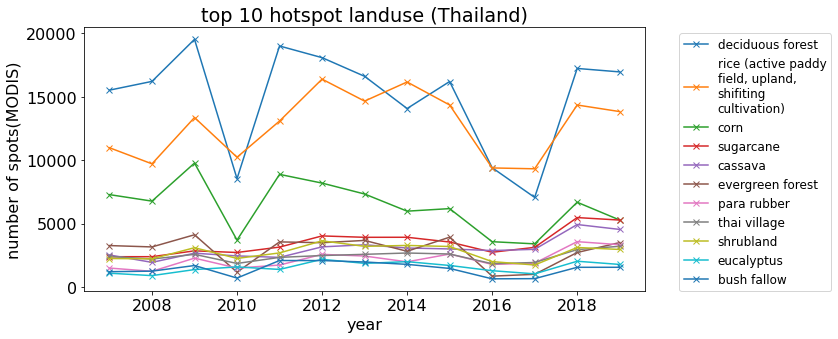

In [326]:
_, ax = plt.subplots(figsize=(12, 5))
ax.set_title('top 10 hotspot landuse (Thailand)')
temp.plot(marker='x', ax=ax)
labels = [ '\n'.join(wrap(l, 20)) for l in temp.columns]

ax.legend( labels, bbox_to_anchor=(1.05, 1), fontsize=12)
ax.set_ylabel('number of spots(MODIS)')
ax.set_xlabel('year')
plt.tight_layout()
plt.savefig(report_folder + 'country_top_10_hotspots.png', dpi=300 )

pie chart 

In [6]:
def cal_fire_mean(fire_year):
    
    fire_mean = fire_year.median(axis=1).round(0) 
    
    fire_mean.name = 'mean_spot'
    fire_mean = fire_mean.reset_index()
    fire_mean = fire_mean[['lucode_l3', 'des_en_l3', 'mean_spot']]
    fire_mean['lucode_l2'] = fire_mean['lucode_l3'].str[:2]
    fire_mean['lucode_l1'] = fire_mean['lucode_l2'].str[:1]
    fire_mean = fire_mean.merge(label2, on ='lucode_l2', how='left')
    fire_mean = fire_mean.merge(label1, on ='lucode_l1', how='left')
    return fire_mean

def add_degree(df, round_level =3):
    # convert to percent, add degree for pie chart
    df['spot_per'] = df['mean_spot']/df['mean_spot'].sum() 
    df['spot_per'] = df['spot_per'].astype(float).round(round_level)
    df['degree'] = df['spot_per']*360 
    df['degree'] = df['degree'].astype(int)
    return df
    
def cal_l1_group(fire_mean):
    # level 1 group
    l1_count = fire_mean.groupby(['des_en_l1'], as_index=False).sum()
    l1_count = l1_count.sort_values('des_en_l1', ascending=False)
    l1_count = add_degree(l1_count)
    
    return l1_count 

def count_sub_fire(mean_data, col = 'des_en_l3', header_num = 5):
    # level 3 group for crops
    # "for subgroup of either level 2, level 3"
    l_count = mean_data.groupby([col], as_index=False).sum()
    l_count = l_count.sort_values('mean_spot', ascending=False)

    to_keep = l_count.head(header_num) 

    other_count = l_count[~l_count[col].isin(to_keep[col])]
    other_count = pd.DataFrame(other_count.sum()).transpose()
    other_count[col] = 'others'

    l_count = pd.concat([to_keep, other_count])
    l_count = l_count.sort_values(col, ascending=True)
    l_count[col] = l_count[col].str.replace('\(active paddy field, upland, shifiting cultivation\)', '')
    # convert to percent 
    l_count = add_degree(l_count)
    return l_count


In [7]:
def plot_pie(df, col, title='', explode = [], filename=None, startangle=45):
    fig, ax = plt.subplots(1,1, figsize=(11,8))
    
    if len(explode) == 0:
        explode = tuple(np.zeros(len(df)))
    
    wedges, texts, autotexts = ax.pie(df['degree'], autopct='%1.1f%%', startangle=startangle, labels = df[col].to_list(), explode= explode, shadow=False )
    
    #wedges, texts, autotexts = ax.pie(df['degree'], autopct='%1.1f%%', startangle=startangle, labels = df[col].to_list(), shadow=False )
     
    ax.axis('equal')
    for text in texts:
        text.set_fontsize(20)  
   
    labels = [ str(round(p*100/360, 1)) +'%' + ' '+s   for s, p in zip(df[col], df['degree'])]

    #ax.legend(wedges, labels,
    #          title="factors",
    #          loc="upper right", bbox_to_anchor=(1.3, 0.9))
    plt.title(title)
    plt.setp(autotexts, size=20, weight="bold")
    plt.tight_layout()
    if filename:
        plt.savefig(filename, dpi=300)
        
        
def plot_bar(df, x, y, title='', filename=None):
    _, ax = plt.subplots(figsize=(10, 6))
    df.plot(x, y, kind='bar' , color=[ u'#1f77b4', u'#ff7f0e', u'#2ca02c', u'#d62728' ], ax=ax,
            linewidth=1,
            edgecolor='black',
            legend=False, error_kw=dict(ecolor='black', lw=1, capsize=4, capthick=1))

    ax.set_ylabel(y)
    ax.set_xlabel(None)
    ax.set_title(title)
    plt.tight_layout()
    
    if filename:
        plt.savefig(filename, dpi=300)
    return ax

In [453]:
fire_mean = cal_fire_mean(fire_year_all)
print(fire_mean.shape)
fire_mean.head()

(197, 8)


,lucode_l3,des_en_l3,mean_spot,lucode_l2,lucode_l1,des_th_l2,des_en_l2,des_en_l1
0,F201,deciduous forest,13622.0,F2,F,ป่าผลัดใบ,Deciduous forest,forest
1,A101,"rice (active paddy field, upland, shifiting cu...",11148.0,A1,A,พื้นที่นา,Paddy field,farm and corp
2,A203,sugarcane,3148.0,A2,A,พืชไร่,Field crop,farm and corp
3,A204,cassava,2970.0,A2,A,พืชไร่,Field crop,farm and corp
4,A202,corn,4826.0,A2,A,พืชไร่,Field crop,farm and corp


In [460]:
# level 1 group
l1_count = cal_l1_group(fire_mean)

l1_count

,des_en_l1,mean_spot,spot_per,degree
1,farm and corp,40168.0,0.541,194
2,forest,20042.0,0.270,97
0,built-up land,4902.0,0.066,23
3,miscellaneous land,4563.0,0.061,21
4,water,4534.0,0.061,21


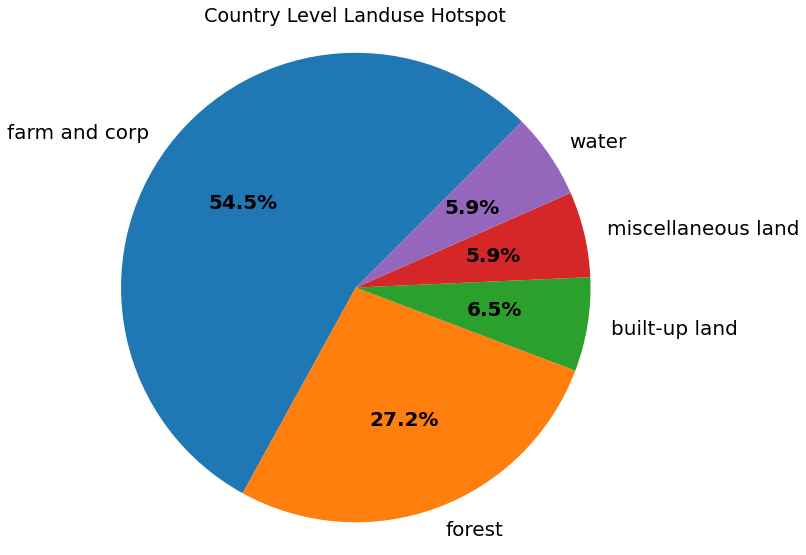

In [461]:
plot_pie(l1_count, col='des_en_l1', title='Country Level Landuse Hotspot', filename=report_folder + 'country_l1_pie.png')

In [465]:
df = fire_mean[fire_mean['des_en_l1'] == 'farm and corp']
l_count = count_sub_fire(df, col = 'des_en_l3', header_num = 6)
l_count

,des_en_l3,mean_spot,spot_per,degree
93,"rice (active paddy field, upland, shifiting cu...",13387,0.333,119
28,corn,6684,0.166,59
104,sugarcane,3148,0.078,28
21,cassava,2970,0.074,26
77,para rubber,1984,0.049,17
37,eucalyptus,1583,0.039,14
0,others,10412,0.259,93


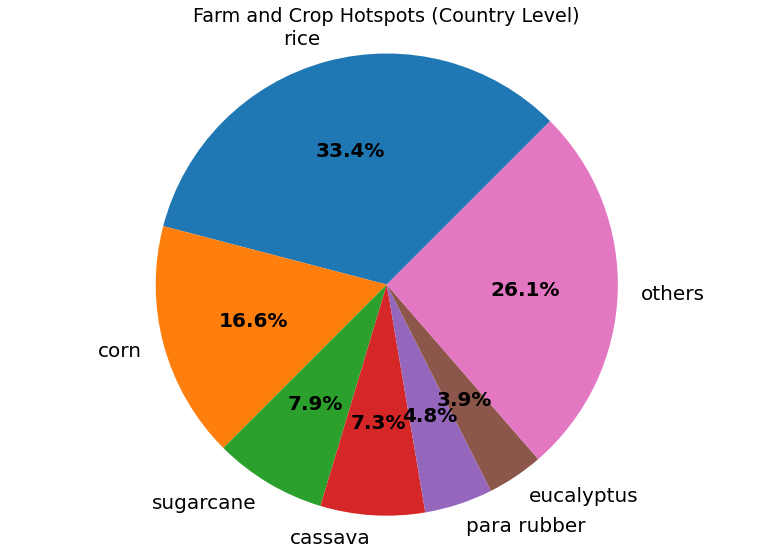

In [478]:
l_count.loc[93, 'des_en_l3'] = 'rice'
plot_pie(l_count, col='des_en_l3', title='Farm and Crop Hotspots (Country Level)', filename=report_folder + 'country_farm_pie.png')

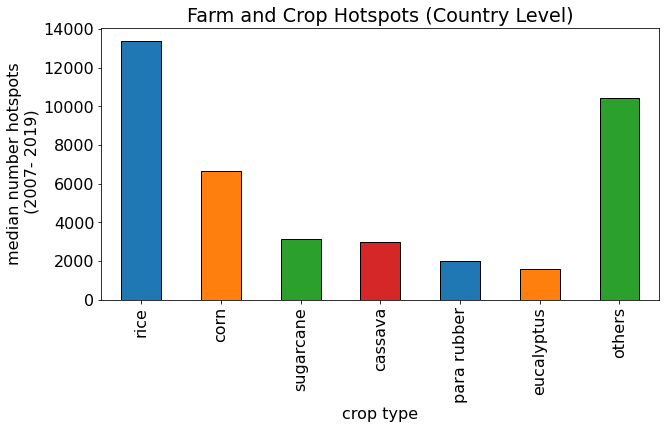

In [481]:
ax = plot_bar(l_count, 'des_en_l3', 'mean_spot', title='Farm and Crop Hotspots (Country Level)')
ax.set_xlabel('crop type')
ax.set_ylabel('median number hotspots\n (2007- 2019)')
plt.savefig(report_folder + 'country_farm_bar.png', dpi=300 )

## ChiangMai Hotspot analysis

In [4]:
dataset = Dataset('Chiang Mai')
y = dataset.city_info['long_m']
x = dataset.city_info['lat_m']

In [483]:
report_folder = 'C:/Users/Benny/Documents/Fern/aqi_thailand2/reports/Thailand/'

In [5]:
year_range = np.arange(2007, 2020)
print(year_range)
fire_filenames = [f'../data/poll_map/th_fire_years_m_proc_label/th_fire_m_{year}.csv' for year in year_range]
print(fire_filenames)

[2007 2008 2009 2010 2011 2012 2013 2014 2015 2016 2017 2018 2019]
['../data/poll_map/th_fire_years_m_proc_label/th_fire_m_2007.csv', '../data/poll_map/th_fire_years_m_proc_label/th_fire_m_2008.csv', '../data/poll_map/th_fire_years_m_proc_label/th_fire_m_2009.csv', '../data/poll_map/th_fire_years_m_proc_label/th_fire_m_2010.csv', '../data/poll_map/th_fire_years_m_proc_label/th_fire_m_2011.csv', '../data/poll_map/th_fire_years_m_proc_label/th_fire_m_2012.csv', '../data/poll_map/th_fire_years_m_proc_label/th_fire_m_2013.csv', '../data/poll_map/th_fire_years_m_proc_label/th_fire_m_2014.csv', '../data/poll_map/th_fire_years_m_proc_label/th_fire_m_2015.csv', '../data/poll_map/th_fire_years_m_proc_label/th_fire_m_2016.csv', '../data/poll_map/th_fire_years_m_proc_label/th_fire_m_2017.csv', '../data/poll_map/th_fire_years_m_proc_label/th_fire_m_2018.csv', '../data/poll_map/th_fire_years_m_proc_label/th_fire_m_2019.csv']


In [8]:
distance = 200E3
fire_year_all = []

for year, file in zip(year_range, fire_filenames):
    fire = pd.read_csv(file)
    # keep fire close to the city 
    fire['distance'] = np.sqrt((fire['lat_m'] - x)**2 + (fire['long_m'] - y)**2)
    fire = fire[fire['distance'] <= distance]
    
    fire = proc_l3_name(fire)
    fire_year = fire.groupby(['lucode_l3', 'des_en_l3', 'des_th_l3']).count()[['latitude']]
    fire_year.columns = [year]
    fire_year_all.append(fire_year)
    
fire_year_all = pd.concat(fire_year_all, axis=1)
fire_year_all = fire_year_all.fillna(0)
fire_year_all = fire_year_all.astype(int)
fire_year_all = fire_year_all.sort_values(year_range[-1], ascending=False)

In [486]:
fire_year_all.head(20)

,,2007,2008,2009,2010,2011,2012,2013,2014,2015,2016,2017,2018,2019
des_en_l3,des_th_l3,,,,,,,,,,,,,
deciduous forest,ป่าผลัดใบ,7631,8567,9435,3451,10652,8374,8386,7001,7100,4208,3218,7855,7331
corn,ข้าวโพด,2780,2915,4304,1491,4442,3765,3331,2671,3011,1508,1416,3589,2524
"rice (active paddy field, upland, shifiting cultivation)","ข้าว (นาข้าว, หมุนเวียน, ข้าวไร่)",3117,3130,4087,1672,4334,3826,3617,3149,2672,1195,1159,2009,2088
evergreen forest,ป่าดิบ,1662,1690,2261,704,2521,2324,2295,1815,1933,428,504,1617,1600
bush fallow,ไร่หมุนเวียนร้าง,1025,1074,1478,654,1839,1712,1621,1452,1181,492,458,1151,1259
longan,ลำไย,546,521,733,255,774,456,554,376,447,312,216,572,498
para rubber,ยางพารา,116,126,374,128,358,374,305,187,286,163,123,587,439
mixed field crop,พืชไร่ผสม,810,915,1219,308,1063,903,891,773,554,155,151,334,402
"rice (active paddy field, upland, shifiting cultivation)","ข้าว (นาข้าว, ไร่หมุนเวียน, ข้าวไร่)",330,445,751,260,875,614,539,515,530,147,139,509,388


In [556]:
ignore_list = ['river, canal', 'river, canal', 'farm pond', 'thai village', 'hill tribe village']
fire_to_plot = fire_year_all.head(10 + len(ignore_list))

In [557]:
fire_to_plot = fire_to_plot.reset_index()
fire_to_plot = fire_to_plot.drop(['des_th_l3', 'lucode_l3'], axis = 1)
fire_to_plot = fire_to_plot[~fire_to_plot['des_en_l3'].isin(ignore_list)]
fire_to_plot = fire_to_plot.set_index('des_en_l3') 
temp = fire_to_plot.transpose()

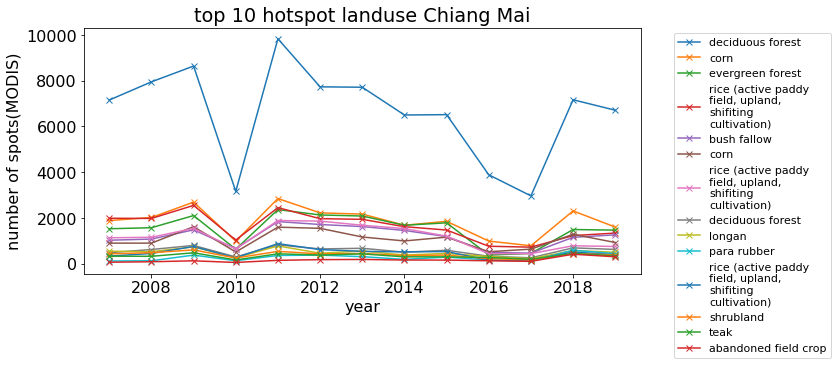

In [558]:
_, ax = plt.subplots(figsize=(12, 5))
ax.set_title(f'top 10 hotspot landuse {dataset.city_name}')
temp.plot(marker='x', ax=ax)
labels = [ '\n'.join(wrap(l, 20)) for l in temp.columns]

ax.legend( labels, bbox_to_anchor=(1.05, 1), fontsize=11)
ax.set_ylabel('number of spots(MODIS)')
ax.set_xlabel('year')
plt.tight_layout()
plt.savefig(report_folder + f'{dataset.city_name}_{int(distance/1000)}_top_10_hotspots.png', dpi=300 )

In [559]:
fire_mean = cal_fire_mean(fire_year_all)
print(fire_mean.shape)
fire_mean.head()

(159, 8)


,lucode_l3,des_en_l3,mean_spot,lucode_l2,lucode_l1,des_th_l2,des_en_l2,des_en_l1
0,F201,deciduous forest,7153.0,F2,F,ป่าผลัดใบ,Deciduous forest,forest
1,A202,corn,1884.0,A2,A,พืชไร่,Field crop,farm and corp
2,F101,evergreen forest,1571.0,F1,F,ป่าไม่ผลัดใบ,Evergreen forest,forest
3,A101,"rice (active paddy field, upland, shifiting cu...",1616.0,A1,A,พื้นที่นา,Paddy field,farm and corp
4,A600,bush fallow,1181.0,A6,A,ไร่หมุนเวียน,Shifting cultivation,farm and corp


In [560]:
# level 1 group
l1_count = cal_l1_group(fire_mean)

l1_count

,des_en_l1,mean_spot,spot_per,degree
1,farm and corp,11056.0,0.491,176
2,forest,9603.0,0.426,153
0,built-up land,644.0,0.029,10
3,miscellaneous land,636.0,0.028,10
4,water,583.0,0.026,9


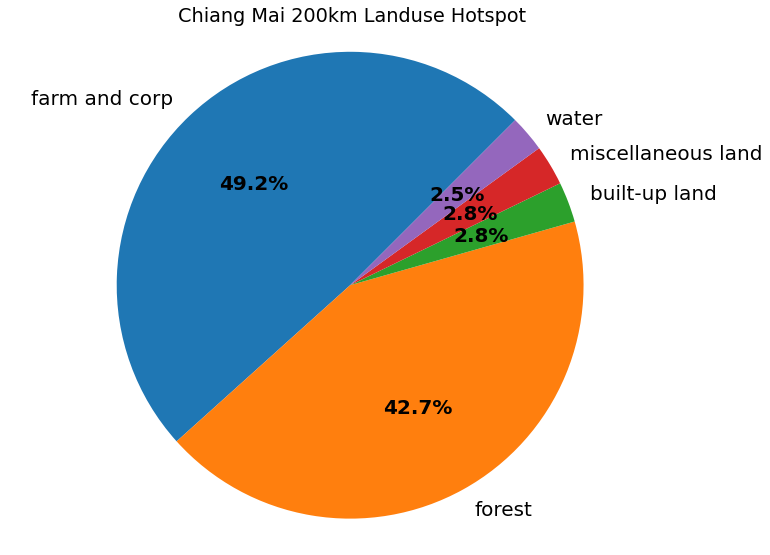

In [561]:
plot_pie(l1_count, col='des_en_l1', title='Chiang Mai 200km Landuse Hotspot', filename=report_folder + f'{dataset.city_name}_{int(distance/1000)}_l1_pie.png')

In [562]:
df = fire_mean[fire_mean['des_en_l1'] == 'farm and corp']
l_count = count_sub_fire(df, col = 'des_en_l3', header_num = 6)
l_count

,des_en_l3,mean_spot,spot_per,degree
75,"rice (active paddy field, upland, shifiting cu...",3278,0.296,106
25,corn,2876,0.260,93
15,bush fallow,1181,0.107,38
51,mixed field crop,762,0.069,24
46,longan,498,0.045,16
91,teak,326,0.029,10
0,others,2135,0.193,69


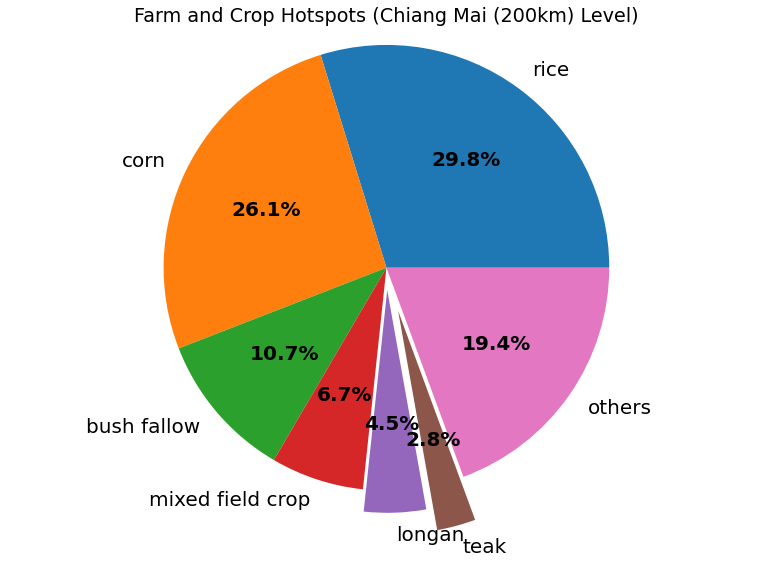

In [563]:
l_count.loc[75, 'des_en_l3'] = 'rice'
plot_pie(l_count, col='des_en_l3', title='Farm and Crop Hotspots (Chiang Mai (200km) Level)', startangle=0, explode=(0,0,0,0,0.1,0.2,0), filename=report_folder + f'{dataset.city_name}_{int(distance/1000)}_farm_pie.png')

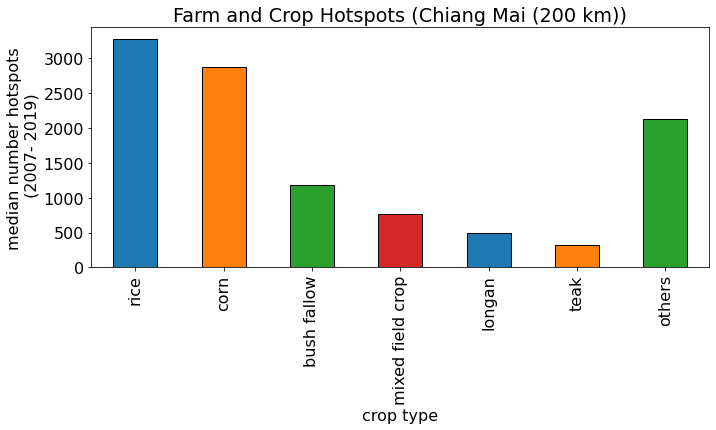

In [564]:
ax = plot_bar(l_count, 'des_en_l3', 'mean_spot', title='Farm and Crop Hotspots (Chiang Mai (200 km))')
ax.set_xlabel('crop type')
ax.set_ylabel('median number hotspots\n (2007- 2019)')
plt.savefig(report_folder + f'{dataset.city_name}_{int(distance/1000)}_farm_bar.png', dpi=300 )

In [10]:
# add level 2 and level 1
fire_year_all = fire_year_all.reset_index()
fire_year_all['lucode_l2'] = fire_year_all['lucode_l3'].str[:2]
fire_year_all['lucode_l1'] = fire_year_all['lucode_l2'].str[:1]
fire_year_all = fire_year_all.merge(label2, on ='lucode_l2', how='left')
fire_year_all = fire_year_all.merge(label1, on ='lucode_l1', how='left')

In [13]:
fire_year_all.to_csv('../data/chiang_mai/' + 'fire_m_lld_label.csv', index=False)

## Bangkok Hotspot analysis

In [ ]:
dataset = Dataset('Bangkok')
y = dataset.city_info['long_m']
x = dataset.city_info['lat_m']

In [ ]:
report_folder = 'C:/Users/Benny/Documents/Fern/aqi_thailand2/reports/Thailand/'

In [ ]:
year_range = np.arange(2007, 2020)
print(year_range)
fire_filenames = [f'../data/poll_map/th_fire_years_m_proc_label/th_fire_m_{year}.csv' for year in year_range]
print(fire_filenames)

In [ ]:
distance = 200E3
fire_year_all = []

for year, file in zip(year_range, fire_filenames):
    fire = pd.read_csv(file)
    # keep fire close to the city 
    fire['distance'] = np.sqrt((fire['lat_m'] - x)**2 + (fire['long_m'] - y)**2)
    fire = fire[fire['distance'] <= distance]
    
    fire = proc_l3_name(fire)
    fire_year = fire.groupby(['lucode_l3', 'des_en_l3', 'des_th_l3']).count()[['latitude']]
    fire_year.columns = [year]
    fire_year_all.append(fire_year)
    
fire_year_all = pd.concat(fire_year_all, axis=1)
fire_year_all = fire_year_all.fillna(0)
fire_year_all = fire_year_all.astype(int)
fire_year_all = fire_year_all.sort_values(year_range[-1], ascending=False)

In [ ]:
fire_year_all.head(20)

In [ ]:
ignore_list = ['river, canal', 'river, canal', 'farm pond', 'thai village', 'hill tribe village', 'road', 'farm pond','irrigation canal']
fire_to_plot = fire_year_all.head(10 + len(ignore_list))

In [ ]:
fire_to_plot = fire_to_plot.reset_index()
fire_to_plot = fire_to_plot.drop(['des_th_l3', 'lucode_l3'], axis = 1)
fire_to_plot = fire_to_plot[~fire_to_plot['des_en_l3'].isin(ignore_list)]
fire_to_plot = fire_to_plot.set_index('des_en_l3') 
temp = fire_to_plot.transpose()

In [ ]:
_, ax = plt.subplots(figsize=(12, 5))
ax.set_title(f'top 10 hotspot landuse {dataset.city_name}')
temp.plot(marker='x', ax=ax)
labels = [ '\n'.join(wrap(l, 20)) for l in temp.columns]

ax.legend( labels, bbox_to_anchor=(1.05, 1), fontsize=11)
ax.set_ylabel('number of spots(MODIS)')
ax.set_xlabel('year')
plt.tight_layout()
plt.savefig(report_folder + f'{dataset.city_name}_{int(distance/1000)}_top_10_hotspots.png', dpi=300 )

In [ ]:
fire_mean = cal_fire_mean(fire_year_all)
print(fire_mean.shape)
fire_mean.head()

In [ ]:
# level 1 group
l1_count = cal_l1_group(fire_mean)

l1_count = l1_count.dropna()

In [ ]:
plot_pie(l1_count, col='des_en_l1', title=f'{dataset.city_name} 200km Landuse Hotspot', filename=report_folder + f'{dataset.city_name}_{int(distance/1000)}_l1_pie.png')

In [ ]:
df = fire_mean[fire_mean['des_en_l1'] == 'farm and corp']
l_count = count_sub_fire(df, col = 'des_en_l3', header_num = 6)
l_count = l_count.dropna()

In [ ]:
l_count.loc[77, 'des_en_l3'] = 'rice'
plot_pie(l_count, col='des_en_l3', title=f'Farm and Crop Hotspots ({dataset.city_name} (200km) Level)', startangle=0, filename=report_folder + f'{dataset.city_name}_{int(distance/1000)}_farm_pie.png')

In [ ]:
ax = plot_bar(l_count, 'des_en_l3', 'mean_spot', title=f'Farm and Crop Hotspots ({dataset.city_name} (200 km))')
ax.set_xlabel('crop type')
ax.set_ylabel('median number hotspots\n (2007- 2019)')
plt.savefig(report_folder + f'{dataset.city_name}_{int(distance/1000)}_farm_bar.png', dpi=300 )

## Province with MostHotspots

In [ ]:
filename = map_folder + 'THA.gdb'
# select province level
prov_map = gpd.read_file(filename, driver='FileGDB', layer=2)
prov_map['geometry'].shape
# overide old crs and convert
crs = pyproj.CRS('EPSG:4326')
prov_map['geometry'] = prov_map['geometry'].set_crs(crs, allow_override=True)
prov_map['geometry'] = prov_map['geometry'].to_crs('EPSG:3857')
prov_map["area(km2)"] = prov_map['geometry'].area/ 10**6
prov_area_df = prov_map[['admin1Name_en', "area(km2)"]]

In [ ]:
# find province wtih most hotspot
top_provs = []
for year, file in zip(year_range, fire_filenames):
    fire = pd.read_csv(file)
    fire = proc_l3_name(fire)
    fire_year = fire.groupby('province').count()[['lucode_l3']]
    fire_year.columns = [year]
    top_provs.append(fire_year)
    
top_provs = pd.concat(top_provs, axis=1)
top_provs = top_provs.fillna(0)
top_provs = top_provs.astype(int)
top_provs = top_provs.sort_values(year_range[-1], ascending=False)
top_provs['mean'] = top_provs.mean(axis=1)
top_provs = top_provs.reset_index()
top_provs = top_provs.merge(prov_area_df, left_on='index', right_on = 'admin1Name_en', how='left')
top_provs['mean/area'] = top_provs['mean']/ top_provs["area(km2)"]

In [ ]:
prov_list = top_provs.sort_values('mean', ascending=False).head()['index'].to_list() + top_provs.sort_values('mean/area', ascending=False).head()['index'].to_list()
prov_list = np.unique(prov_list)

In [ ]:
fire_year_all = []

for year, file in zip(year_range, fire_filenames):
    fire = pd.read_csv(file)
    fire = proc_l3_name(fire)
    fire_year = fire.groupby(['province', 'des_en_l3']).count()[['lucode_l3']]
    fire_year.columns = [year]
    fire_year_all.append(fire_year)
    
fire_year_all = pd.concat(fire_year_all, axis=1)
fire_year_all = fire_year_all.fillna(0)
fire_year_all = fire_year_all.astype(int)
fire_year_all = fire_year_all.reset_index()

In [ ]:
ignore_list = ['river, canal', 'river, canal', 'farm pond', 'thai village', 'hill tribe village']
for prov in prov_list:
    prov_fire = fire_year_all[fire_year_all['province'] == prov]
    prov_fire = prov_fire.sort_values(year_range[-1], ascending=False)
    
    fire_to_plot = prov_fire.head(10 + len(ignore_list))
    fire_to_plot = fire_to_plot[~fire_to_plot['des_en_l3'].isin(ignore_list)]
    fire_to_plot = fire_to_plot.set_index('des_en_l3') 
    fire_to_plot = fire_to_plot.drop('province', axis=1)
    temp = fire_to_plot.transpose()
    
    _, ax = plt.subplots(figsize=(12, 5))
    ax.set_title(f'{prov} top 10 hotspot landuse')
    temp.plot(marker='x', ax=ax)
    labels = [ '\n'.join(wrap(l, 20)) for l in temp.columns]

    ax.legend( labels, bbox_to_anchor=(1.05, 1), fontsize=11)
    ax.set_ylabel('number of spots(MODIS)')
    ax.set_xlabel('year')
    plt.tight_layout()
    plt.savefig(report_folder + f'{prov}_top_10_hotspots.png', dpi=300 )

## Regional analysis

In [ ]:
mdataset = MapDataset('Thailand')
# load station and geopanda file for Thailand
mdataset.load_()
# load provinces & region information 
provinces = mdataset.prov_map[['region', 'province']]
provinces['region'] = provinces['region'].str.replace('Greater Bangkok', 'Central Region')
provinces['area(km2)'] = mdataset.prov_map['geometry'].area/ 10**6
region_area_df = provinces.groupby('region', as_index=False).sum()

In [ ]:
# find province wtih most hotspot
top_provs = []
for year, file in zip(year_range, fire_filenames):
    fire = pd.read_csv(file)
    fire = proc_l3_name(fire)
    fire = fire.merge(provinces, on='province', how='left')
    fire_year = fire.groupby('region').count()[['lucode_l3']]
    fire_year.columns = [year]
    top_provs.append(fire_year)
    
top_provs = pd.concat(top_provs, axis=1)
top_provs = top_provs.fillna(0)
top_provs = top_provs.astype(int)
top_provs = top_provs.sort_values(year_range[-1], ascending=False)
top_provs['mean'] = top_provs.mean(axis=1)
top_provs = top_provs.reset_index()
top_provs = top_provs.merge(region_area_df, on = 'region', how='left')
top_provs['mean/area'] = top_provs['mean']/ top_provs["area(km2)"]

In [ ]:
top_provs.sort_values('mean', ascending=False).head()['region'] 

In [ ]:
top_provs.sort_values('mean/area', ascending=False).head()['region'] 

In [ ]:
fire_year_all = []

for year, file in zip(year_range, fire_filenames):
    fire = pd.read_csv(file)
    fire = proc_l3_name(fire)
    fire = fire.merge(provinces, on='province', how='left')
    fire_year = fire.groupby(['region', 'lucode_l3', 'des_en_l3']).count()[['latitude']]
    fire_year.columns = [year]
    fire_year_all.append(fire_year)
    
fire_year_all = pd.concat(fire_year_all, axis=1)
fire_year_all = fire_year_all.fillna(0)
fire_year_all = fire_year_all.astype(int)
fire_year_all = fire_year_all.reset_index()

In [ ]:
ignore_list = ['river, canal', 'river, canal', 'farm pond', 'thai village', 'hill tribe village', 'road', 'institutional land']

for region in provinces['region'].unique():
    prov_fire = fire_year_all[fire_year_all['region'] == region]
    prov_fire = prov_fire.sort_values(year_range[-1], ascending=False)
    
    fire_to_plot = prov_fire.head(10 + len(ignore_list))
    fire_to_plot = fire_to_plot[~fire_to_plot['des_en_l3'].isin(ignore_list)]
    fire_to_plot = fire_to_plot.set_index('des_en_l3') 
    fire_to_plot = fire_to_plot.drop(['region', 'lucode_l3'], axis=1)
    temp = fire_to_plot.transpose()
    print(region, ":", fire_to_plot.head(5).index.to_list())
    
    _, ax = plt.subplots(figsize=(12, 5))
    ax.set_title(f'{region} top 10 hotspot landuse')
    temp.plot(marker='x', ax=ax)
    labels = [ '\n'.join(wrap(l, 20)) for l in temp.columns]

    ax.legend( labels, bbox_to_anchor=(1.05, 1), fontsize=12)
    ax.set_ylabel('number of spots(MODIS)')
    ax.set_xlabel('year')
    plt.tight_layout()
    plt.savefig(report_folder + f'{region}_top_10_hotspots.png', dpi=300 )

In [ ]:
fire_year_all.head()

In [ ]:
for region in provinces['region'].unique():
    prov_fire = fire_year_all[fire_year_all['region'] == region]
    prov_fire = prov_fire.drop('region', axis=1)
    prov_fire = prov_fire.set_index(['lucode_l3', 'des_en_l3'])
    fire_mean = cal_fire_mean(prov_fire)
    # level 1 group
    l1_count = cal_l1_group(fire_mean)
    plot_pie(l1_count, col='des_en_l1', title=f'{region} Landuse Hotspot', filename=report_folder + f'{region}_l1_pie.png')
    
    df = fire_mean[fire_mean['des_en_l1'] == 'farm and corp']
    l_count = count_sub_fire(df, col = 'des_en_l3', header_num = 6)
    l_count['des_en_l3'] = l_count['des_en_l3'].str.replace('\(active paddy field, upland, shifiting cultivation\)', '')
    plot_pie(l_count, col='des_en_l3', title=f'Farm and Crop Hotspots ({region})', startangle=0, filename=report_folder + f'{region}_farm_pie.png')
    
    ax = plot_bar(l_count, 'des_en_l3', 'mean_spot', title=f'Farm and Crop Hotspots ({region})')
    ax.set_xlabel('crop type')
    ax.set_ylabel('median number hotspots\n (2007- 2019)')
    plt.savefig(report_folder + f'{region}_farm_bar.png', dpi=300 )

# Label lucode level VIIRS

In [ ]:
prov_folder = '../data/poll_map/th_fire_years_v_prov_proc/'
pro_fire_folder = '../data/poll_map/th_fire_years_v_proc/'
new_fire_folder = '../data/poll_map/th_fire_years_v_proc_label/'
report_folder = 'C:/Users/Benny/Documents/Fern/aqi_thailand2/reports/Thailand/'
if not os.path.exists(new_fire_folder):
    os.mkdir(new_fire_folder)

In [ ]:
# process province files 
year = 2013
prov_files = glob(prov_folder + '*.csv')
year_save_filename = pro_fire_folder + f'th_fire_v_{year}.csv'
label_filename = new_fire_folder   + f'th_fire_v_{year}.csv'
prov_files = [s for s in files if str(year) in s]
print('prov_file lenght ', len(prov_files))
print('save to file ' + year_safe_filename)
print('label to file ' + label_filename)

In [ ]:
# merge all province files and save 
year_fire = []
for file in prov_files:

    year_fire.append(pd.read_csv(file))

year_fire = pd.concat(year_fire)
year_fire.to_csv(year_save_filename, index=False)

In [ ]:
year_fire.head()

In [ ]:
# add labels 
fire_files = [year_save_filename]
for filename in fire_files:
    save_filename = filename.replace('th_fire_years_v_proc', 'th_fire_years_v_proc_label')
    print(save_filename)
    fire = pd.read_csv(filename, encoding='iso_8859_11')
    if 'geometry' in fire.columns:
        fire = fire.drop('geometry', axis=1)

    fire['lucode'] = fire['lucode'].replace('+', '/')
    # fix lucode with /
    fire = expland_lucode(fire)
    # merge lucode level 3 
    fire = fire.merge(label3, left_on='lucode', right_on='lucode_l3', how='left')
    fire['lucode_l2'] = fire['lucode'].str[:2]
    # merge lucode level 2 
    fire = fire.merge(label2,  on='lucode_l2',  how='left')
    #fire = fire.drop(['lucode', 'long_m', 'lat_m'], axis=1)
    fire.to_csv(save_filename, index=False, encoding= 'utf-8')

## Country Level: Compare MODIS and VIIRS

In [ ]:
ignore_list = ['river, canal', 'river, canal', 'farm pond', 'thai village', 'hill tribe village', 'road', 'farm pond','irrigation canal']

In [ ]:
# 
year = 2013
v_fire = pd.read_csv(f'../data/poll_map/th_fire_years_v_proc_label/th_fire_v_{year}.csv')
v_fire = proc_l3_name(v_fire)
v_fire = v_fire.groupby(['lucode_l3', 'des_en_l3', 'des_th_l3']).count()[['latitude']]
v_fire  = cal_fire_mean(v_fire)
print(v_fire.shape) 
v_l1_count = cal_l1_group(v_fire)

In [ ]:
m_fire = pd.read_csv(f'../data/poll_map/th_fire_years_m_proc_label/th_fire_m_{year}.csv') 
m_fire = proc_l3_name(m_fire)
m_fire = m_fire.groupby(['lucode_l3', 'des_en_l3', 'des_th_l3']).count()[['latitude']]
m_fire  = cal_fire_mean(m_fire)
print(m_fire.shape)
# level 1 group
m_l1_count = cal_l1_group(m_fire)

In [ ]:
plot_pie(m_l1_count, col='des_en_l1', title=f'Country Level Landuse Hotspot MODIS {year}', filename=report_folder + f'modis_{year}_country_l1_pie.png', startangle=-45)

In [ ]:
plot_pie(v_l1_count, col='des_en_l1', title=f'Country Level Landuse Hotspot VIIRS {year}', filename=report_folder + f'viirs_{year}_country_l1_pie.png', startangle=-45)

In [ ]:
df = m_fire[m_fire['des_en_l1'] == 'farm and corp']
m_l_count = count_sub_fire(df, col = 'des_en_l3', header_num = 5)
m_l_count

In [ ]:
df = v_fire[v_fire['des_en_l1'] == 'farm and corp']
v_l_count = count_sub_fire(df, col = 'des_en_l3', header_num = 5)
v_l_count

In [ ]:
plot_pie(m_l_count, col='des_en_l3', title='Farm and Crop Hotspots (Country Level) (MODIS top 5)', filename=report_folder + f'modis_{year}_country_farm_pie.png', startangle=0)

In [ ]:
plot_pie(v_l_count, col='des_en_l3', title='Farm and Crop Hotspots (Country Level) (VIIRS top 5)', filename=report_folder + f'viirs_{year}_country_farm_pie.png', startangle=0)

## Bangkok

In [ ]:
dataset = Dataset('Bangkok')
y = dataset.city_info['long_m']
x = dataset.city_info['lat_m']
distance = 200E3

In [ ]:
# 
year = 2013
v_fire = pd.read_csv(f'../data/poll_map/th_fire_years_v_proc_label/th_fire_v_{year}.csv')
v_fire['distance'] = np.sqrt((v_fire['lat_m'] - x)**2 + (v_fire['long_m'] - y)**2)
v_fire = v_fire[v_fire['distance'] <= distance]
v_fire = proc_l3_name(v_fire)
v_fire = v_fire.groupby(['lucode_l3', 'des_en_l3', 'des_th_l3']).count()[['latitude']]
v_fire  = cal_fire_mean(v_fire)
print(v_fire.shape) 
v_l1_count = cal_l1_group(v_fire)

In [ ]:
m_fire = pd.read_csv(f'../data/poll_map/th_fire_years_m_proc_label/th_fire_m_{year}.csv') 
m_fire['distance'] = np.sqrt((m_fire['lat_m'] - x)**2 + (m_fire['long_m'] - y)**2)
m_fire = m_fire[m_fire['distance'] <= distance]
m_fire = proc_l3_name(m_fire)
m_fire = m_fire.groupby(['lucode_l3', 'des_en_l3', 'des_th_l3']).count()[['latitude']]
m_fire  = cal_fire_mean(m_fire)
print(m_fire.shape)
# level 1 group
m_l1_count = cal_l1_group(m_fire)

In [ ]:
plot_pie(m_l1_count, col='des_en_l1', title=f'{dataset.city_name} 200km Landuse Hotspot(MODIS)', filename=report_folder + f'modis_{year}_{dataset.city_name}_{int(distance/1000)}_l1_pie.png', startangle=-45)

In [ ]:
plot_pie(m_l1_count, col='des_en_l1', title=f'{dataset.city_name} 200km Landuse Hotspot(VIIRS)', filename=report_folder + f'viirs_{year}_{dataset.city_name}_{int(distance/1000)}_l1_pie.png', startangle=-45)

In [ ]:
df = m_fire[m_fire['des_en_l1'] == 'farm and corp']
m_l_count = count_sub_fire(df, col = 'des_en_l3', header_num = 5)
m_l_count

In [ ]:
df = v_fire[v_fire['des_en_l1'] == 'farm and corp']
v_l_count = count_sub_fire(df, col = 'des_en_l3', header_num = 5)
v_l_count

In [ ]:
plot_pie(m_l_count, col='des_en_l3', title=f'Farm and Crop Hotspots ({dataset.city_name} 200km) (MODIS top 5)', filename=report_folder + f'modis_{year}_{dataset.city_name}_{int(distance/1000)}_farm_pie.png', startangle=0)

In [ ]:
plot_pie(v_l_count, col='des_en_l3', title=f'Farm and Crop Hotspots ({dataset.city_name} 200km) (VIIRS top 5)', filename=report_folder + f'viirs_{year}_{dataset.city_name}_{int(distance/1000)}_farm_pie.png', startangle=0)